In [1]:
import subprocess
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
import copy 
import os
import glob
import warnings
from os.path import join as pjoin

import scipy.io
import nilearn
from nilearn import image
from nilearn.glm import threshold_stats_img
from nilearn.glm.first_level import make_first_level_design_matrix, FirstLevelModel
from nilearn.plotting import plot_design_matrix, plot_stat_map, plot_glass_brain

def mkdir_no_exist(d): os.makedirs(d, exist_ok=True)

from nilearn.plotting import plot_img, plot_glass_brain
import matplotlib.pyplot as plt


# repetition has to be known
TR = 0.72 

In [2]:
def pretty_print(files, n_toprint=None, basepath=False):
    to_print = files
    if n_toprint is not None:
        to_print = to_print[:n_toprint]
    for f in to_print:
        print(os.path.basename(f) if basepath else f)

Note that the data have already been preprocessed (removal of nuosance regressor, coregistration, normalization to mni)

# Task selection



In [3]:
HCP_dir = '/media/miplab-nas2/HCP-Data'
paradigm_dir = pjoin(HCP_dir,'HCP_100unrelated_TaskParadigms')
fMRI_dir = pjoin(HCP_dir,'HCP_100unrelated_preprocessed_ERG/data')

project_dir = '/media/RCPNAS/Data2/CS-433-ML4S/'
project_data_dir = pjoin(project_dir, 'data')
derivatives_dir = pjoin(project_data_dir, 'derivatives')

anat_dir = pjoin(derivatives_dir, 'anat')
func_dir = pjoin(derivatives_dir, 'func')
events_dir = pjoin(project_data_dir, 'events')

mkdir_no_exist(anat_dir)
mkdir_no_exist(func_dir)
mkdir_no_exist(events_dir)

In [4]:
subject = '113619'
tasktype = 'MOTOR'
acquisition = "RL"

subject_task_prefix = f"{subject}_{tasktype}"

In [5]:
def subject_gm_mask_path(subject):
    return pjoin(anat_dir, f"{subject}_gm_mask.nii.gz")

def subject_task_concat_volumes_path(subject, task, aquisition, smoothing):
    return pjoin(func_dir, f"{subject}_{task}_{aquisition}_smooth-{smoothing}mm_fMRIvols.nii.gz")

def subject_task_fmap(subject, task, aquisition, smoothing):
    return pjoin(func_dir, f"{subject}_{task}_{aquisition}_smooth-{smoothing}mm_fmap.nii.gz")

def processed_event(subject, task, aquisition):
    return pjoin(events_dir, f"{subject}_{task}_{aquisition}_event.csv")

In [6]:
def plot_brain_dist(data, title):
    mask = (data != 0).astype(int)
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8, 2))
    fig.suptitle(title, fontsize=14, y=1.05)
    ax1.plot(np.sum(mask, axis=(1, 2)))
    ax1.set_title('X')
    ax1.grid(True)
    
    ax2.plot(np.sum(mask, axis=(0, 2)))
    ax2.set_title('Y')
    ax2.grid(True)
    
    ax3.plot(np.sum(mask, axis=(0, 1)))
    ax3.set_title('Z')
    ax3.grid(True)
    
    plt.tight_layout()
    plt.show()

In [7]:
def process_gray_matter_mask(anat_dir, subject, border_size=10, save=False, plot=True):
    # Save the 4D image as .nii.gz
    clean_gm_mask_file = subject_gm_mask_path(subject)
    if not os.path.isfile(clean_gm_mask_file):
        warnings.warn(f"mask for {subject} was never extracted")
    print(clean_gm_mask_file)
        
    grey_matter_mask = pjoin(fMRI_dir, subject, 'T1/Atlased/GMmask.nii')

    nifti_image = nib.load(grey_matter_mask)
    mask_data = nifti_image.get_fdata()
    
    plot_brain_dist(mask_data, "original")

    if border_size > 0:
        mask_data[:border_size, :, :] = 0  # Remove borders along the first dimension (x)
        mask_data[-border_size:, :, :] = 0
        mask_data[:, :border_size, :] = 0  # Remove borders along the second dimension (y)
        mask_data[:, -border_size:, :] = 0
        mask_data[:, :, :border_size] = 0  # Remove borders along the third dimension (z)
        mask_data[:, :, -border_size:] = 0

    plot_brain_dist(mask_data, "processed")
        
    clean_gm_mask = nib.Nifti1Image(mask_data, affine=nifti_image.affine, header=nifti_image.header)

    if plot:
        # Plot the resampled gray matter mask
        plot_img(grey_matter_mask, title="Subject's Grey Matter Mask", cut_coords=[-5, -20, 5], figure=plt.figure(figsize=(10, 3)))
        # Plot the resampled gray matter mask
        plot_img(clean_gm_mask, title="Grey Matter Mask with cleaned borders", cut_coords=[-5, -20, 5], figure=plt.figure(figsize=(10, 3)))
    
    # Show the plot
    plt.show()    
    if save:
        nib.save(clean_gm_mask, clean_gm_mask_file)

/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/anat/113619_gm_mask.nii.gz


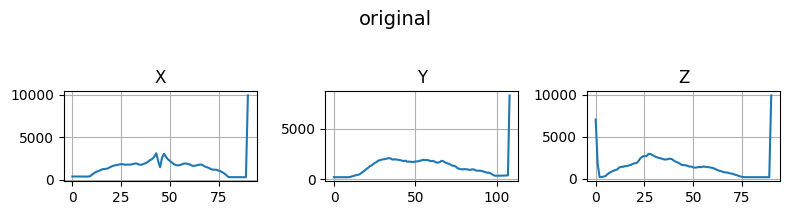

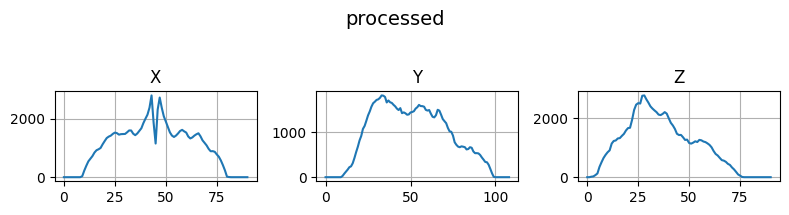

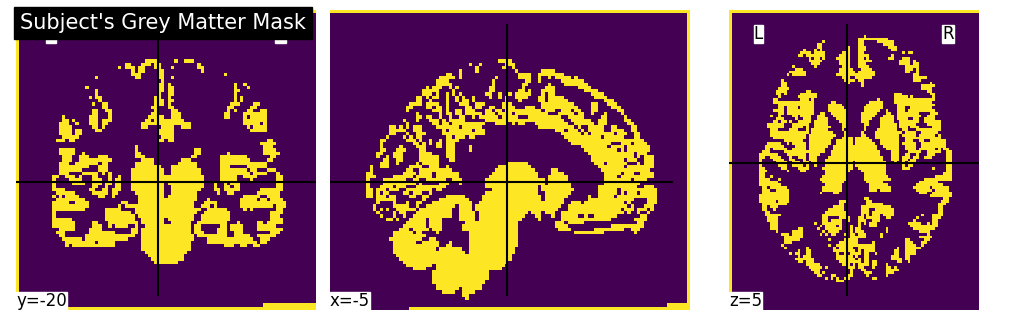

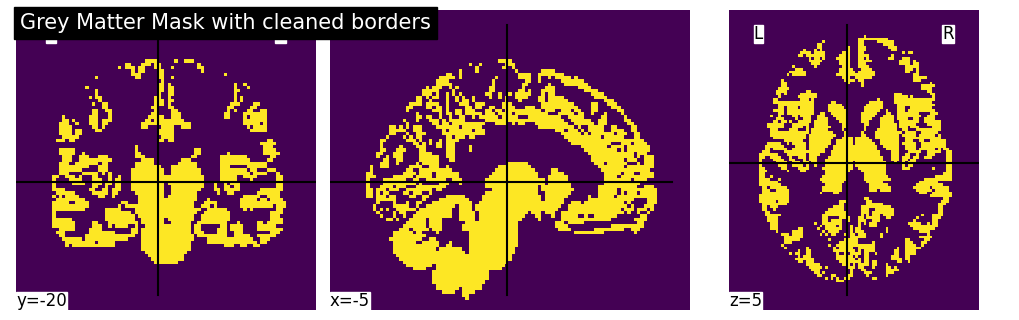

In [8]:
process_gray_matter_mask(anat_dir, subject, border_size=2, save=True)

In [11]:
def create_4d_volume(subject, task, acquisition, smoothing=10, save=False):
    concat_4d_vols_file = subject_task_concat_volumes_path(subject, task, acquisition, smoothing)
    print(concat_4d_vols_file)
    if os.path.isfile(concat_4d_vols_file):
        print(f"files {os.path.basename(concat_4d_vols_file)} already exists, skipping processing")
        return nib.load(concat_4d_vols_file)
    
    nii_directory = os.path.join(fMRI_dir, subject, f"tfMRI_{task}_{acquisition}/fMRIvols_GLMyes/")
    nii_files = sorted(glob.glob(nii_directory + '*.nii'))
    pretty_print(nii_files, n_toprint=2)
    
    first_img = nib.load(nii_files[0])
    data = first_img.get_fdata()  # 3D data from the first file
    data_4d = np.zeros((data.shape[0], data.shape[1], data.shape[2], len(nii_files)))

    for i, nii_file in enumerate(nii_files):
        img = nib.load(nii_file)
        img = image.smooth_img(img, smoothing)
        data_4d[..., i] = img.get_fdata()

    # Create a new NIfTI image
    concat_img = nib.Nifti1Image(data_4d, affine=first_img.affine, header=first_img.header)
    
    if save:
        nib.save(concat_img, concat_4d_vols_file)
        
    return concat_4d_vols_file

In [12]:
create_4d_volume(subject, tasktype, acquisition, smoothing=5, save=True)

/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/func/113619_MOTOR_RL_smooth-5mm_fMRIvols.nii.gz
/media/miplab-nas2/HCP-Data/HCP_100unrelated_preprocessed_ERG/data/113619/tfMRI_MOTOR_RL/fMRIvols_GLMyes/Cov_ftfMRI_MOTOR_RL0001.nii
/media/miplab-nas2/HCP-Data/HCP_100unrelated_preprocessed_ERG/data/113619/tfMRI_MOTOR_RL/fMRIvols_GLMyes/Cov_ftfMRI_MOTOR_RL0002.nii


KeyboardInterrupt: 

In [14]:
def create_events_df(subject, task, acquisition, plot_regressors=False, save_csv=True):
    proced_event = processed_event(subject, task, acquisition)
    
    filepath = pjoin(paradigm_dir, f"{subject}_Regressor_tfMRI_{task}_{acquisition}.mat")
    print(filepath)
    data = scipy.io.loadmat(filepath)

    regressor = data['Regressor']

    # Flatten the regressor to 1D if necessary
    regressor_flat = regressor.flatten()
    if plot_regressors:
        plt.plot(regressor_flat)
    
    # Initialize lists to store onset, duration, and condition (trial type)
    onsets, durations, trial_types = [], [], []

    # Identify events by iterating through the regressor
    current_condition = regressor_flat[0]
    start_time = 0  # Initial start time
    
    for i, condition in enumerate(regressor_flat[1:], start=1):
        if condition == current_condition: 
            continue

        # Append the onset, duration, and trial type of the previous condition
        onsets.append(start_time * TR)
        durations.append((i - start_time) * TR)
        trial_types.append(f'condition_{current_condition}')

        # Update for the new condition
        current_condition = condition
        start_time = i

    # Add the last event
    onsets.append(start_time * TR)
    durations.append((len(regressor_flat) - start_time) * TR)
    trial_types.append(f'condition_{current_condition}')

    # Create the event file as a DataFrame
    events = pd.DataFrame({
        'onset': onsets,
        'duration': durations,
        'trial_type': trial_types
    })

    #Remove condition 0 which is a the no-paradigm condition and reset indexes
    events = events[events['trial_type'] != "condition_0"]
    events = events.reset_index(drop=True)
    
    condition_counts = events['trial_type'].value_counts().to_dict()
    independent_events = copy.deepcopy(events)
    # Modify the trial_type to include the index of each event occurrence
    independent_events['trial_type'] = [f"{row['trial_type']}_{i}" for i, row in events.iterrows()]
    
    if save_csv:
        print(proced_event)
        independent_events.to_csv(proced_event, index=False)
    
    return independent_events

/media/miplab-nas2/HCP-Data/HCP_100unrelated_TaskParadigms/113619_Regressor_tfMRI_WM_RL.mat
/media/RCPNAS/Data2/CS-433-ML4S/data/events/113619_WM_RL_event.csv


onset  duration     trial_type
0    7.92     27.36  condition_5_0
1   36.00     27.36  condition_2_1
2   79.20     27.36  condition_8_2
3  107.28     27.36  condition_1_3
4  150.48     27.36  condition_3_4
5  179.28     27.36  condition_6_5
6  222.48     27.36  condition_4_6
7  250.56     27.36  condition_7_7

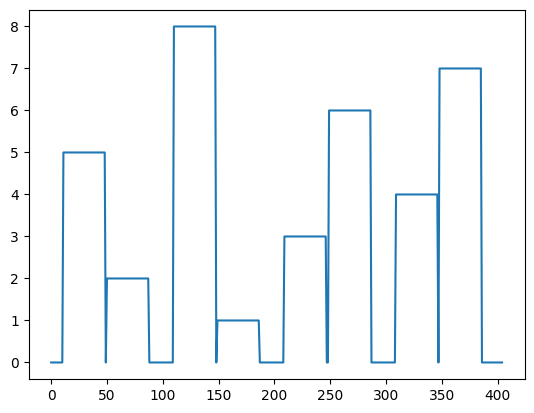

In [15]:
create_events_df(subject, "WM", acquisition, plot_regressors=True, save_csv=True)

In [16]:
create_events_df(subject, tasktype, acquisition, plot_regressors=False)

/media/miplab-nas2/HCP-Data/HCP_100unrelated_TaskParadigms/113619_Regressor_tfMRI_MOTOR_RL.mat
/media/RCPNAS/Data2/CS-433-ML4S/data/events/113619_MOTOR_RL_event.csv


onset  duration     trial_type
0   10.80     11.52  condition_4_0
1   25.92     11.52  condition_2_1
2   56.16     11.52  condition_5_2
3   71.28     11.52  condition_1_3
4   86.40     11.52  condition_3_4
5  115.92     11.52  condition_4_5
6  131.04     11.52  condition_5_6
7  146.88     11.52  condition_2_7
8  162.00     11.52  condition_3_8
9  177.12     11.52  condition_1_9

In [17]:
def plot_fmap(fmap, threshold, display_mode, task="", info=None, cut_cords=7):
    plot_stat_map(
        fmap,
        threshold=threshold,
        title=f"{task} F-stat map, abs(thr) > {threshold} {info}",
        figure=plt.figure(figsize=(15, 3)),
        display_mode=display_mode,
        cut_coords=cut_cords,
        black_bg=True,
        colorbar=True
    )

In [18]:
def plot_fmap_glass(fmap, threshold, task="", info=None):
    plot_glass_brain(
        fmap,
        display_mode='ortho',
        colorbar=True,
        threshold=threshold,
        title=f"{task} F-stat map, abs(thr) > {threshold} {info}",
    )

In [19]:
def compute_task_fmap(subject, task, acquisition, smoothing, fmri_glm, contrast_matrix, save=False):
    fmap_path = subject_task_fmap(subject, task, acquisition, smoothing)
    if os.path.isfile(fmap_path):
        return nib.load(fmap_path)

    f_test_result = fmri_glm.compute_contrast(contrast_matrix, stat_type='F', output_type='stat')
    if save:
        f_test_result.to_filename(fmap_path)
    
    return f_test_result

In [20]:
x_coords = [-52, -26, 0, 26, 52]  # Left to right
y_coords = [-68, -36, -4, 28, 60]  # Posterior to anterior
z_coords = [-40, -24, -8, 8, 24, 40, 56]  # Inferior to superior

def show_task_activation(subject, task, acquisition, smoothing=5, plot_designmatrix=False, cluster_size=None, fdr_rate=0.01, threshold=2, plot_glass=False):
    print("selecting subject gray matter mask")
    gm_mask = subject_gm_mask_path(subject)
    print(gm_mask)
    
    print(f"concatenating volumes for task {task}")
    fmri_vols = create_4d_volume(subject, task, acquisition, smoothing, save=True)
    
    print("processing event conditions")
    independent_events = create_events_df(subject, task, acquisition)
    
    fmri_glm = FirstLevelModel(
        mask_img=gm_mask,
        t_r=TR,
        noise_model='ar1', # or ols 
        standardize=False,
        hrf_model='spm',
        drift_model=None, # not necessary, nuisance covariates have already been removed
    )

    # Fit the model to our design and data
    print(f"fitting GLM for task {task}")
    fmri_glm = fmri_glm.fit(fmri_vols, independent_events)
    
    design_matrix = fmri_glm.design_matrices_[0]
    if plot_designmatrix:
        fig, ax = plt.subplots(figsize=(4, 6))
        plot_design_matrix(design_matrix, ax=ax)
        plt.tight_layout()
        plt.show()

    n_regressors = design_matrix.shape[1] #non usato per ora
    return fmri_glm

selecting subject gray matter mask
/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/anat/113619_gm_mask.nii.gz
concatenating volumes for task MOTOR
/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/func/113619_MOTOR_RL_smooth-10mm_fMRIvols.nii.gz
files 113619_MOTOR_RL_smooth-10mm_fMRIvols.nii.gz already exists, skipping processing
processing event conditions
/media/miplab-nas2/HCP-Data/HCP_100unrelated_TaskParadigms/113619_Regressor_tfMRI_MOTOR_RL.mat
/media/RCPNAS/Data2/CS-433-ML4S/data/events/113619_MOTOR_RL_event.csv
fitting GLM for task MOTOR


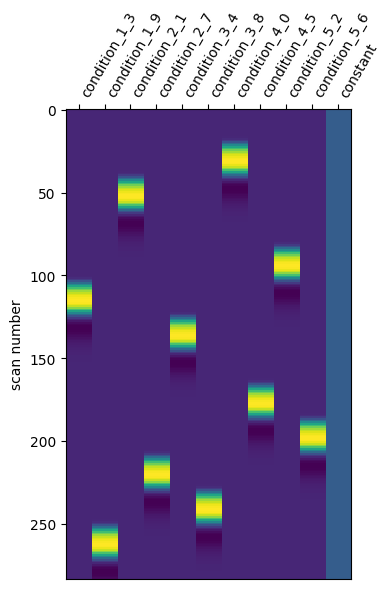

In [23]:
fglm = show_task_activation(subject, "MOTOR", acquisition, smoothing=10, plot_designmatrix=True, cluster_size=10)

selecting subject gray matter mask
/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/anat/113619_gm_mask.nii.gz
concatenating volumes for task MOTOR
/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/func/113619_MOTOR_LR_smooth-5mm_fMRIvols.nii.gz
/media/miplab-nas2/HCP-Data/HCP_100unrelated_preprocessed_ERG/data/113619/tfMRI_MOTOR_LR/fMRIvols_GLMyes/Cov_ftfMRI_MOTOR_LR0001.nii
/media/miplab-nas2/HCP-Data/HCP_100unrelated_preprocessed_ERG/data/113619/tfMRI_MOTOR_LR/fMRIvols_GLMyes/Cov_ftfMRI_MOTOR_LR0002.nii
processing event conditions
/media/miplab-nas2/HCP-Data/HCP_100unrelated_TaskParadigms/113619_Regressor_tfMRI_MOTOR_LR.mat
/media/RCPNAS/Data2/CS-433-ML4S/data/events/113619_MOTOR_LR_event.csv
fitting GLM for task MOTOR


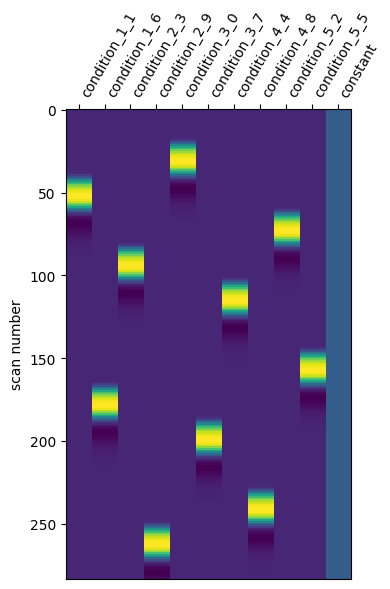

computing fmap


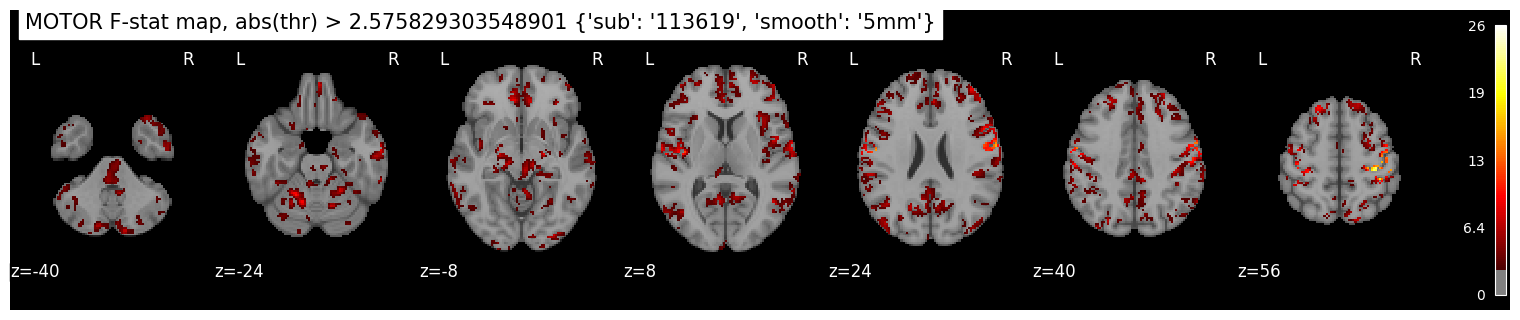

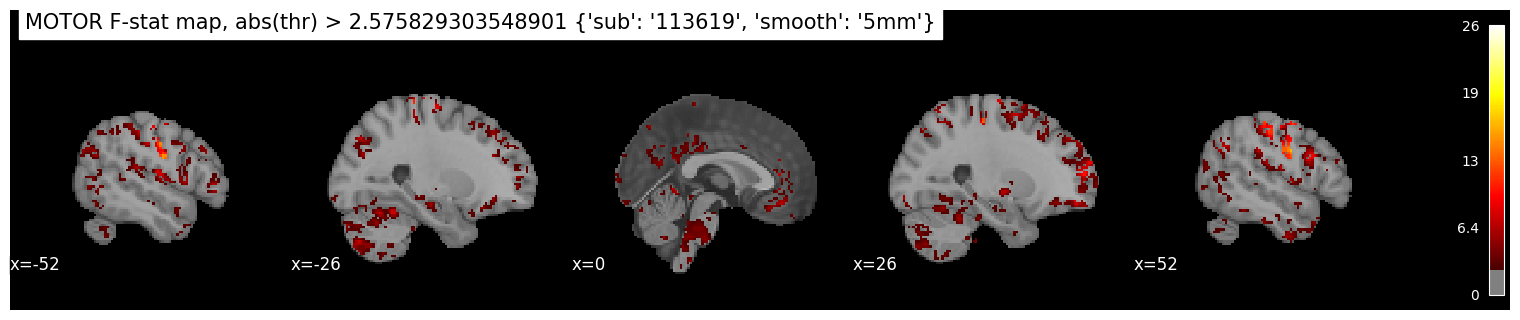

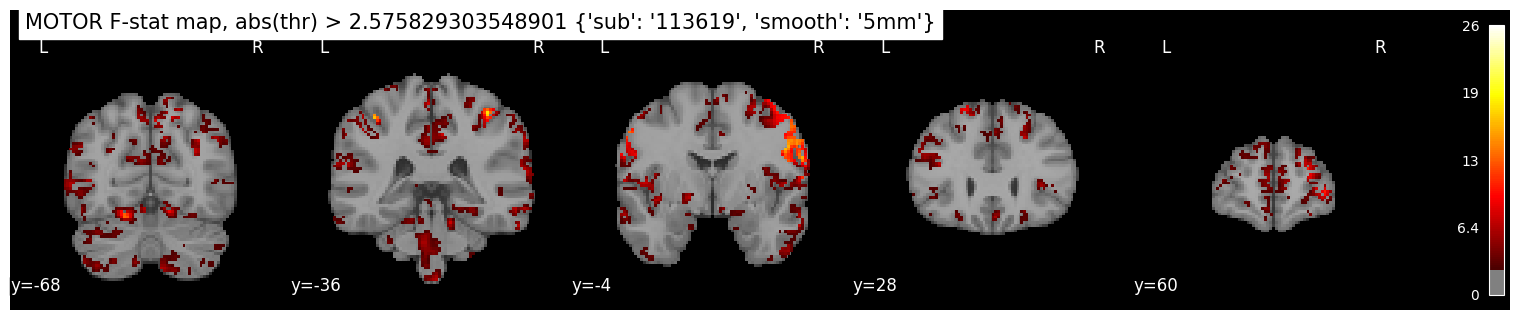

In [34]:
show_task_activation(subject, "MOTOR", "LR", smoothing=5, plot_designmatrix=True, cluster_size=10)

In [60]:
hrf=  fglm.design_matrices_[0]['condition_1_3']
keys =fglm.design_matrices_[0]['condition_1_3'].index

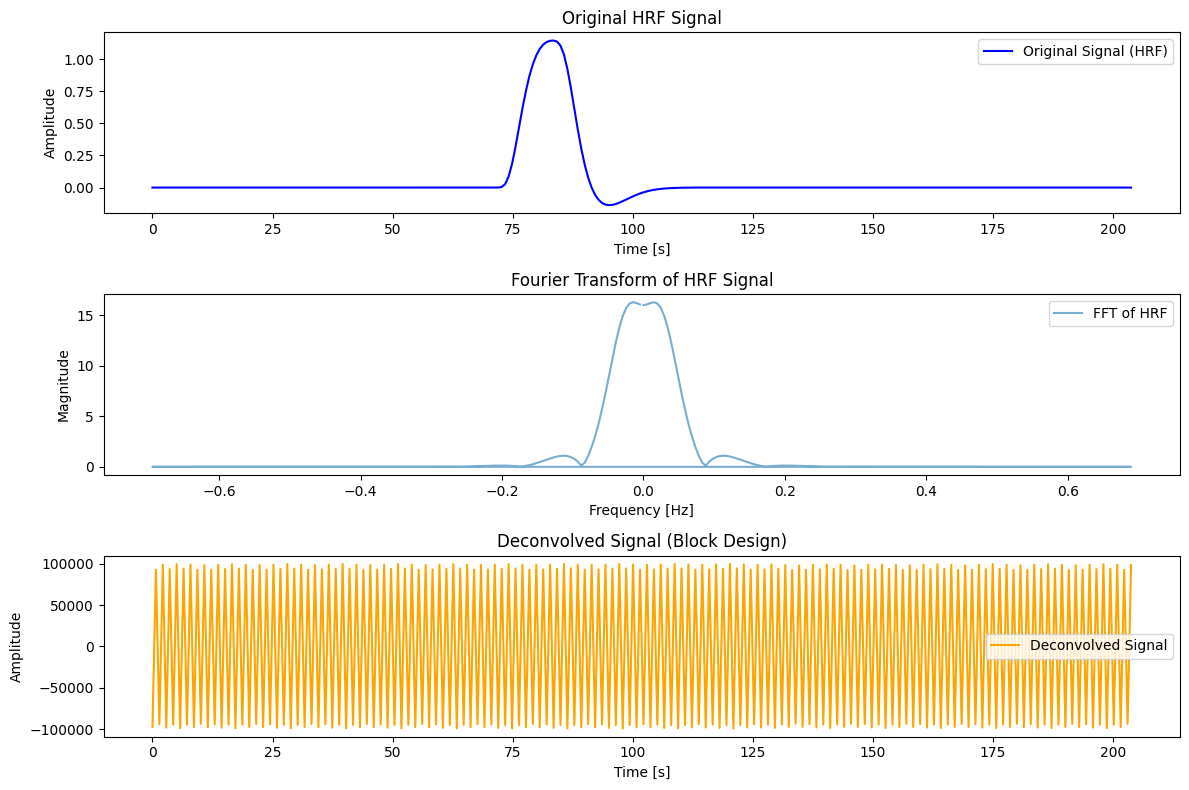

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming `hrf` is a Pandas Series with the HRF signal and timeline as the index
# Example HRF (replace with your actual HRF data)

# Extract the signal values and timeline (time index)
signal_values = hrf.values
time_index = hrf.index

# Fourier Transform (FFT)
fft_signal = np.fft.fft(signal_values)  # Forward FFT

# Frequency axis (for plotting)
freqs = np.fft.fftfreq(len(signal_values), d=(time_index[1] - time_index[0]))

# Avoid division by zero in the frequency domain by adding a small epsilon
epsilon = 1e-10
fft_signal = np.where(np.abs(fft_signal) < epsilon, epsilon, fft_signal)

# Deconvolution: Inverse Fourier Transform (IFFT) of the inverse of the FFT
deconvolved_signal = np.fft.ifft(1 / fft_signal)  # Back to the time domain

# Plotting the results
plt.figure(figsize=(12, 8))

# Original Signal (HRF)
plt.subplot(3, 1, 1)
plt.plot(time_index, signal_values, label='Original Signal (HRF)', color='blue')
plt.title("Original HRF Signal")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.legend()

# Fourier Transform and Filter
plt.subplot(3, 1, 2)
plt.plot(freqs, np.abs(fft_signal), label='FFT of HRF', alpha=0.6)
plt.title("Fourier Transform of HRF Signal")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude")
plt.legend()

# Deconvolved Signal
plt.subplot(3, 1, 3)
plt.plot(time_index, deconvolved_signal.real, label='Deconvolved Signal', color='orange')
plt.title("Deconvolved Signal (Block Design)")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.legend()

plt.tight_layout()
plt.show()


selecting subject gray matter mask
/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/anat/113619_gm_mask.nii.gz
concatenating volumes for task GAMBLING
/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/func/113619_GAMBLING_RL_smooth-5mm_fMRIvols.nii.gz
/media/miplab-nas2/HCP-Data/HCP_100unrelated_preprocessed_ERG/data/113619/tfMRI_GAMBLING_RL/fMRIvols_GLMyes/Cov_ftfMRI_GAMBLING_RL0001.nii
/media/miplab-nas2/HCP-Data/HCP_100unrelated_preprocessed_ERG/data/113619/tfMRI_GAMBLING_RL/fMRIvols_GLMyes/Cov_ftfMRI_GAMBLING_RL0002.nii
processing event conditions
/media/miplab-nas2/HCP-Data/HCP_100unrelated_TaskParadigms/113619_Regressor_tfMRI_GAMBLING_RL.mat
/media/RCPNAS/Data2/CS-433-ML4S/data/events/113619_GAMBLING_RL_event.csv
fitting GLM for task GAMBLING


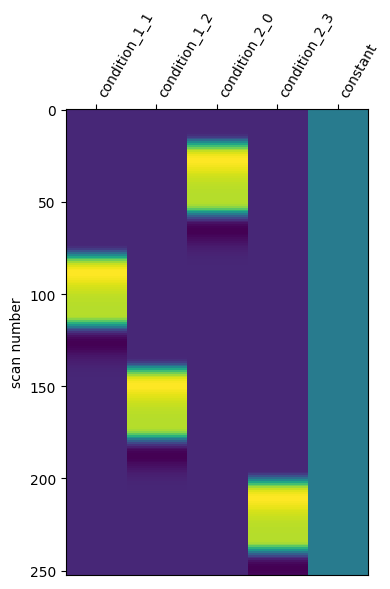

computing fmap


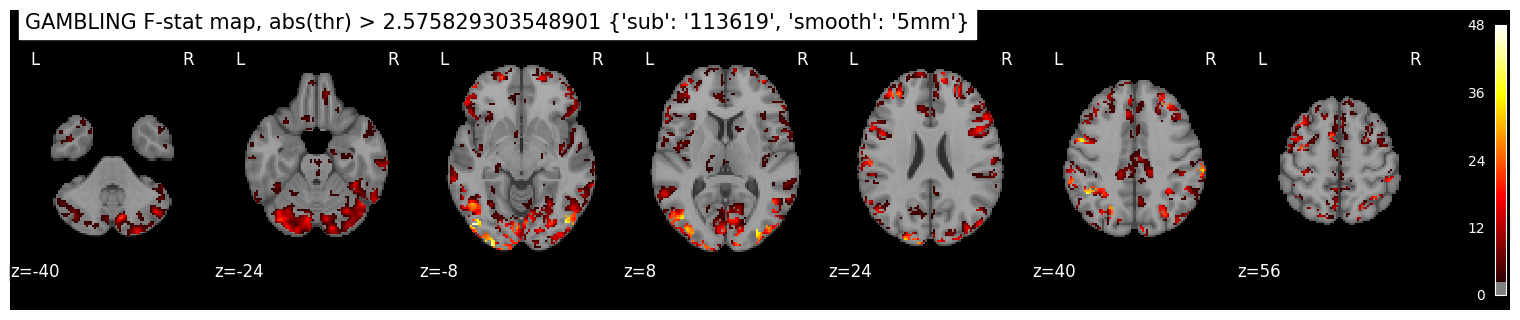

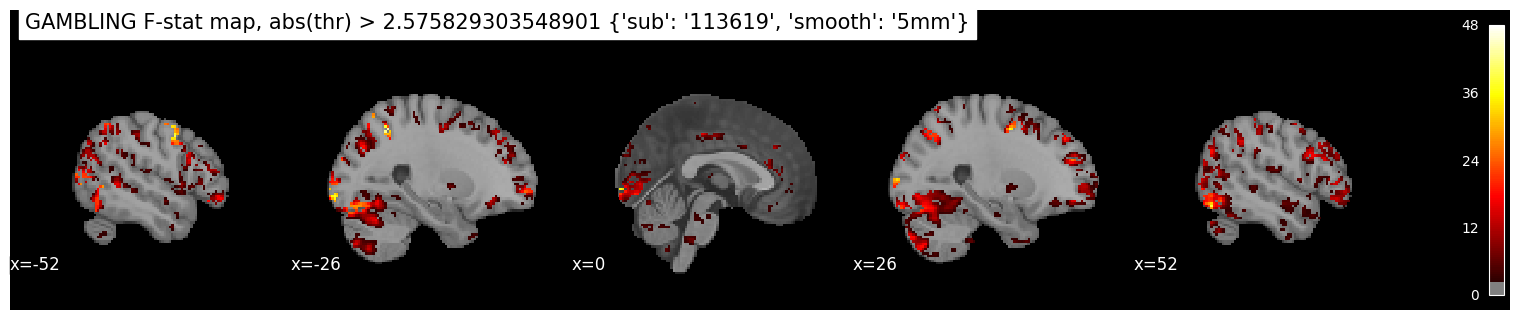

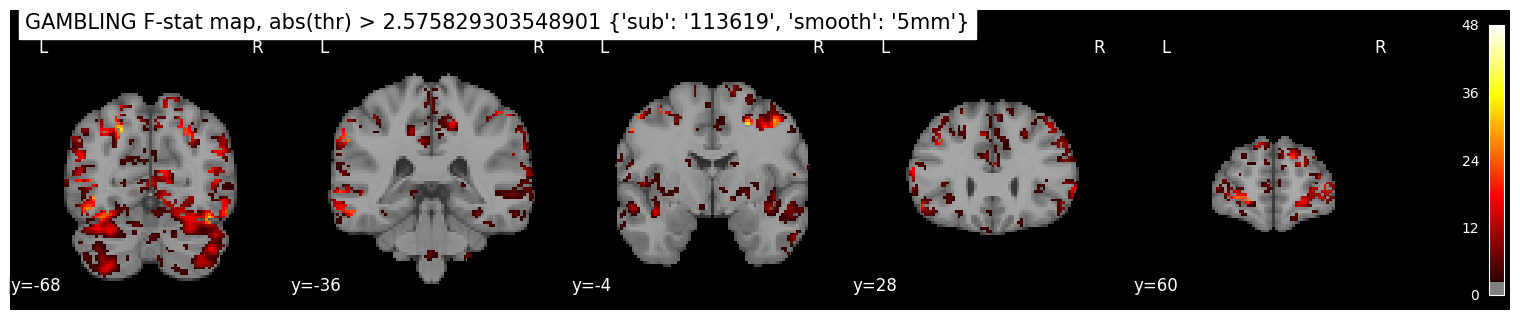

In [33]:
show_task_activation(subject, "GAMBLING", acquisition, smoothing=5, plot_designmatrix=True, cluster_size=10)

In [ ]:
show_task_activation(subject, "WM", acquisition, smoothing=5, plot_designmatrix=True, cluster_size=10)

In [4]:
show_task_activation(subject, "EMOTION", acquisition, smoothing=5, plot_designmatrix=True, cluster_size=10)

NameError: name 'subject' is not defined

selecting subject gray matter mask
/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/anat/113619_gm_mask.nii.gz
concatenating volumes for task LANGUAGE
/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/func/113619_LANGUAGE_RL_smooth-5mm_fMRIvols.nii.gz
files 113619_LANGUAGE_RL_smooth-5mm_fMRIvols.nii.gz already exists, skipping processing
processing event conditions
/media/miplab-nas2/HCP-Data/HCP_100unrelated_TaskParadigms/113619_Regressor_tfMRI_LANGUAGE_RL.mat
/media/RCPNAS/Data2/CS-433-ML4S/data/events/113619_LANGUAGE_RL_event.csv
fitting GLM for task LANGUAGE


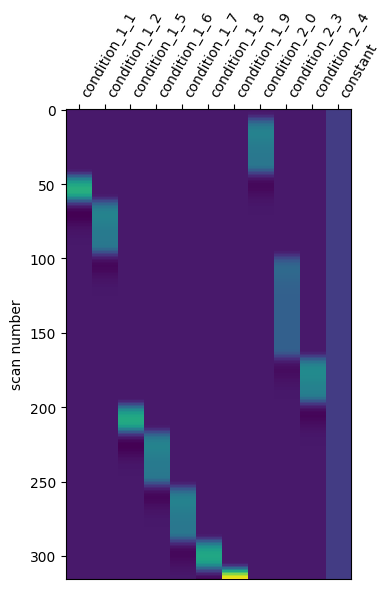

computing fmap


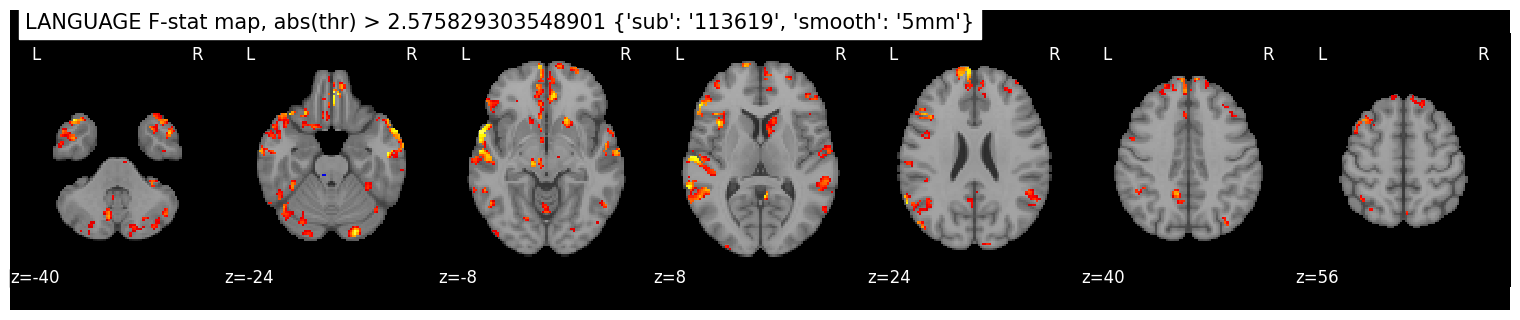

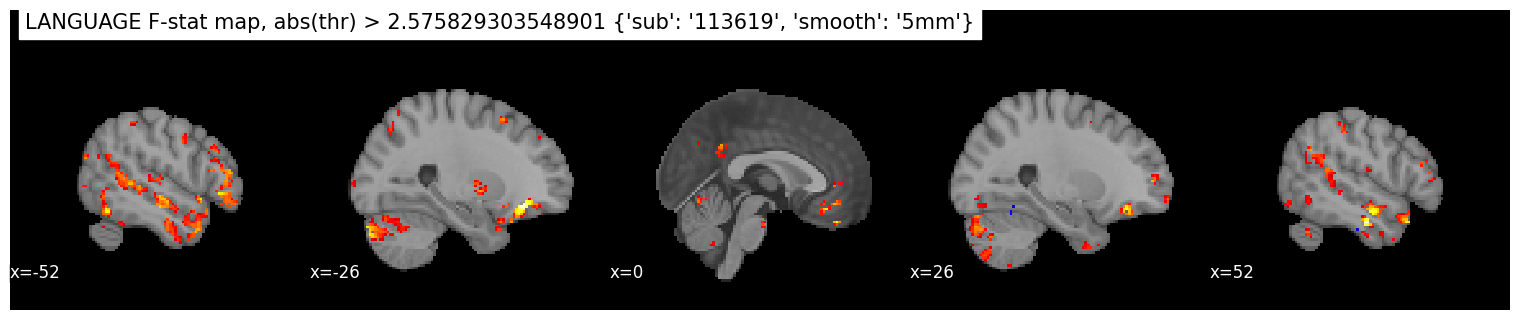

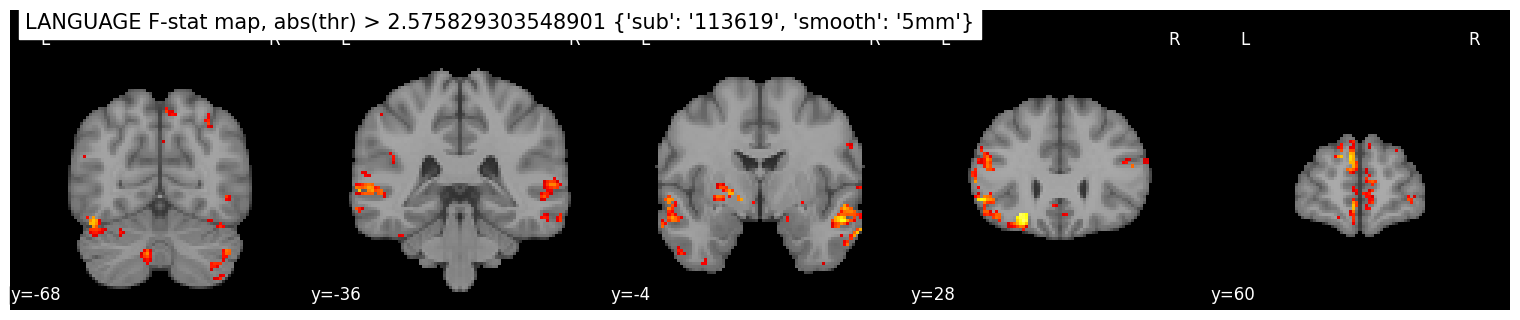

selecting subject gray matter mask
/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/anat/113619_gm_mask.nii.gz
concatenating volumes for task RELATIONAL
/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/func/113619_RELATIONAL_RL_smooth-5mm_fMRIvols.nii.gz
files 113619_RELATIONAL_RL_smooth-5mm_fMRIvols.nii.gz already exists, skipping processing
processing event conditions
/media/miplab-nas2/HCP-Data/HCP_100unrelated_TaskParadigms/113619_Regressor_tfMRI_RELATIONAL_RL.mat
/media/RCPNAS/Data2/CS-433-ML4S/data/events/113619_RELATIONAL_RL_event.csv
fitting GLM for task RELATIONAL


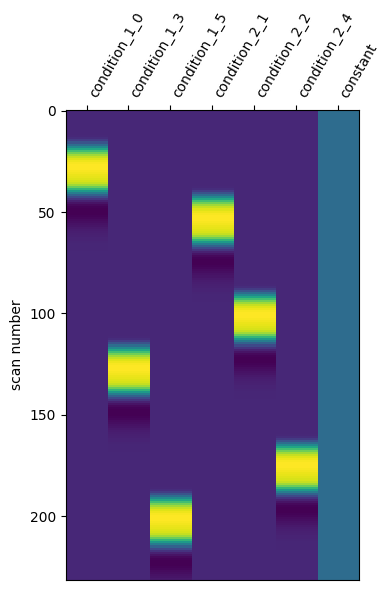

computing fmap


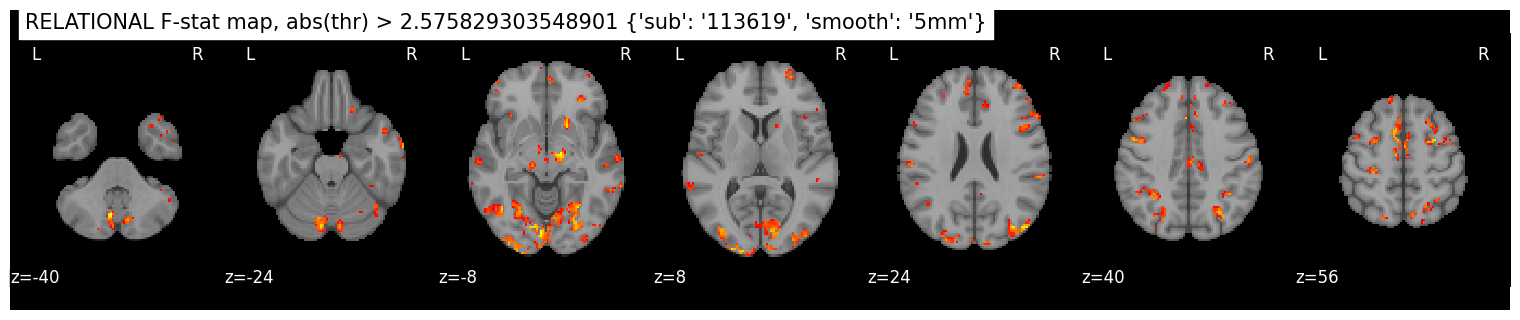

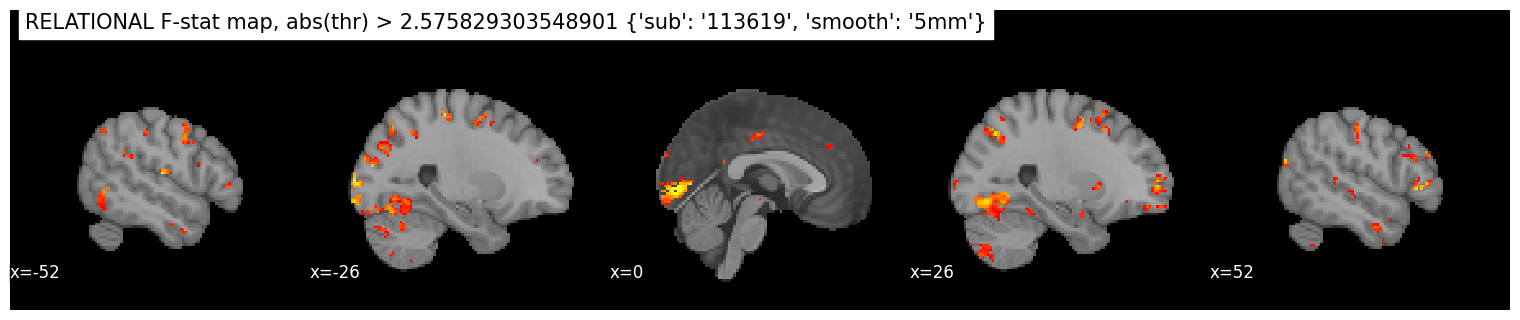

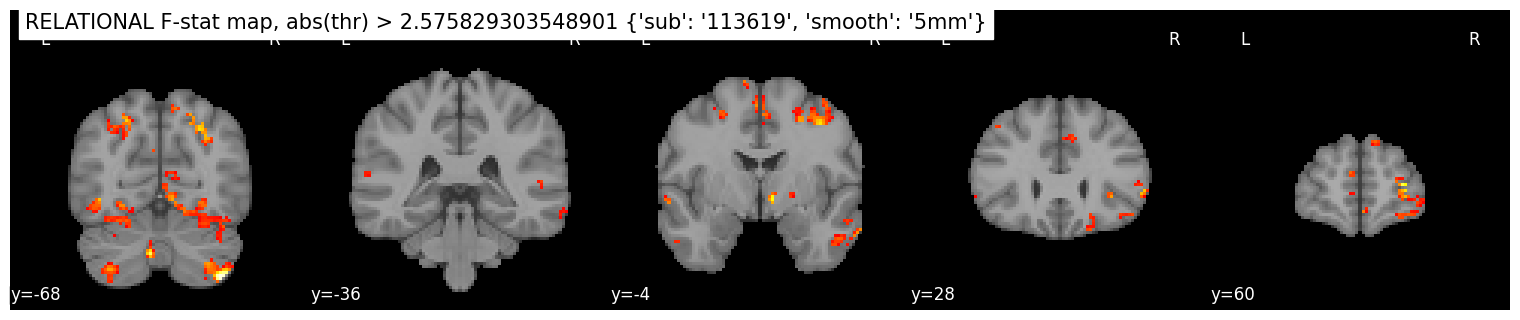

selecting subject gray matter mask
/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/anat/113619_gm_mask.nii.gz
concatenating volumes for task SOCIAL
/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/func/113619_SOCIAL_RL_smooth-5mm_fMRIvols.nii.gz
files 113619_SOCIAL_RL_smooth-5mm_fMRIvols.nii.gz already exists, skipping processing
processing event conditions
/media/miplab-nas2/HCP-Data/HCP_100unrelated_TaskParadigms/113619_Regressor_tfMRI_SOCIAL_RL.mat
/media/RCPNAS/Data2/CS-433-ML4S/data/events/113619_SOCIAL_RL_event.csv
fitting GLM for task SOCIAL


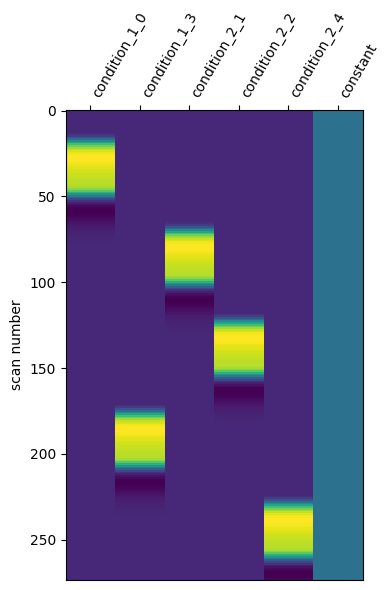

computing fmap


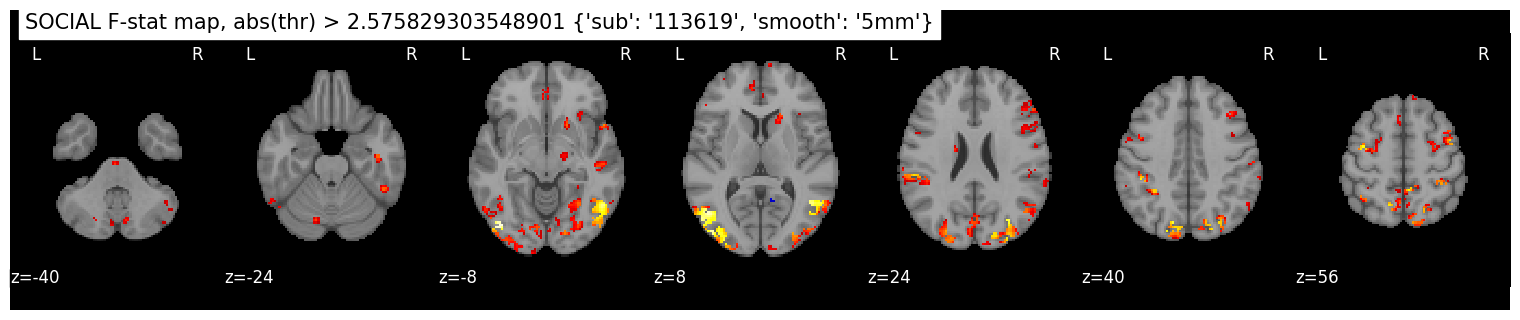

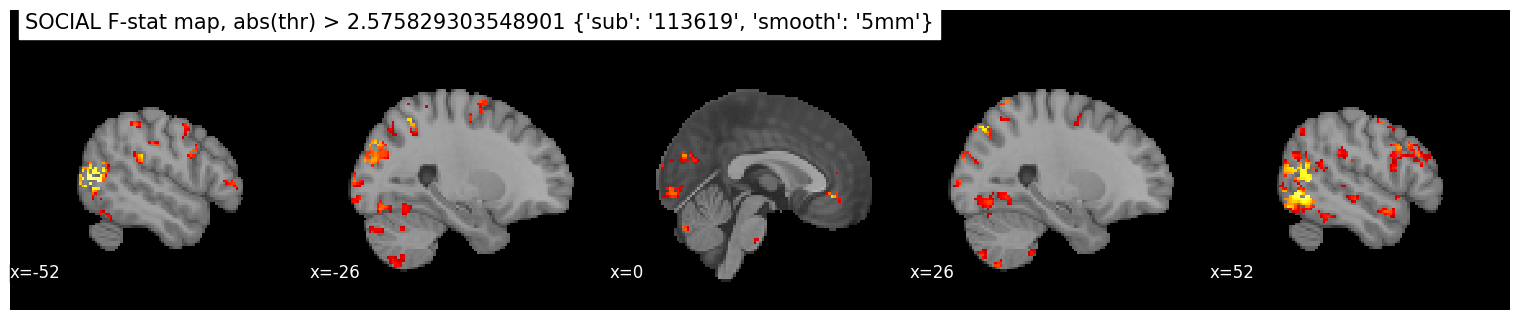

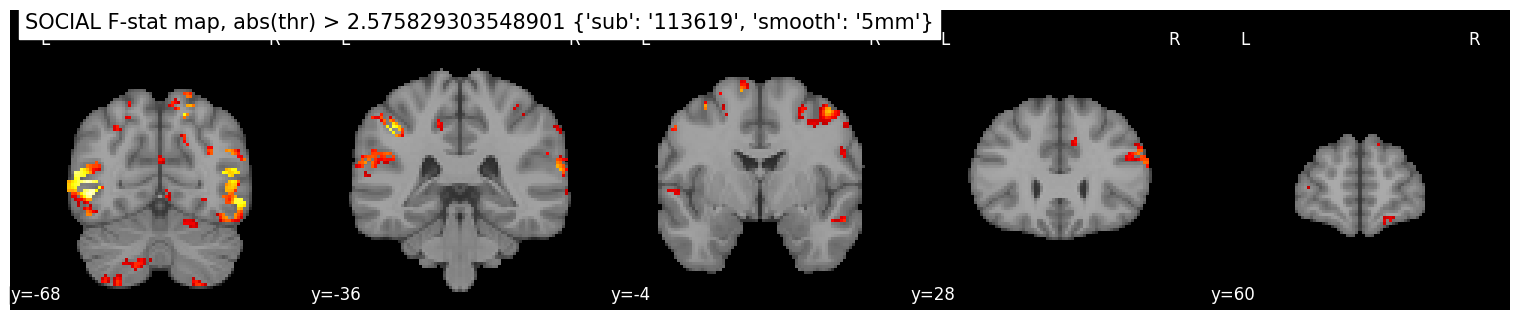

In [24]:
show_task_activation(subject, "LANGUAGE", acquisition, smoothing=5, plot_designmatrix=True, cluster_size=10)
show_task_activation(subject, "RELATIONAL", acquisition, smoothing=5, plot_designmatrix=True, cluster_size=10)
show_task_activation(subject, "SOCIAL", acquisition, smoothing=5, plot_designmatrix=True, cluster_size=10)

selecting subject gray matter mask
/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/anat/113619_gm_mask.nii.gz
concatenating volumes for task LANGUAGE
/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/func/113619_LANGUAGE_RL_smooth-5mm_fMRIvols.nii.gz
files 113619_LANGUAGE_RL_smooth-5mm_fMRIvols.nii.gz already exists, skipping processing
processing event conditions
/media/miplab-nas2/HCP-Data/HCP_100unrelated_TaskParadigms/113619_Regressor_tfMRI_LANGUAGE_RL.mat
/media/RCPNAS/Data2/CS-433-ML4S/data/events/113619_LANGUAGE_RL_event.csv
fitting GLM for task LANGUAGE


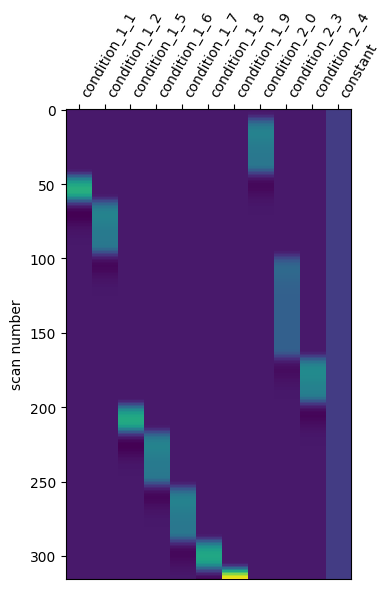

computing fmap


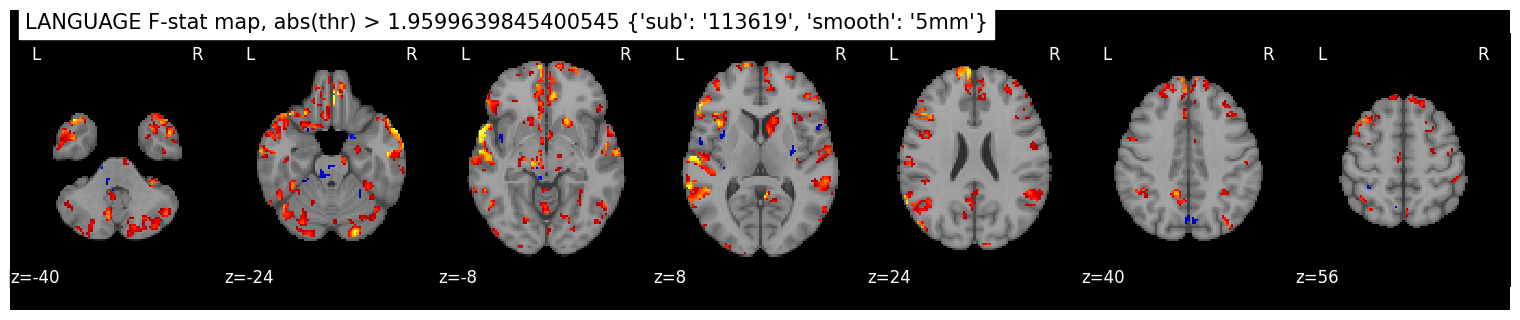

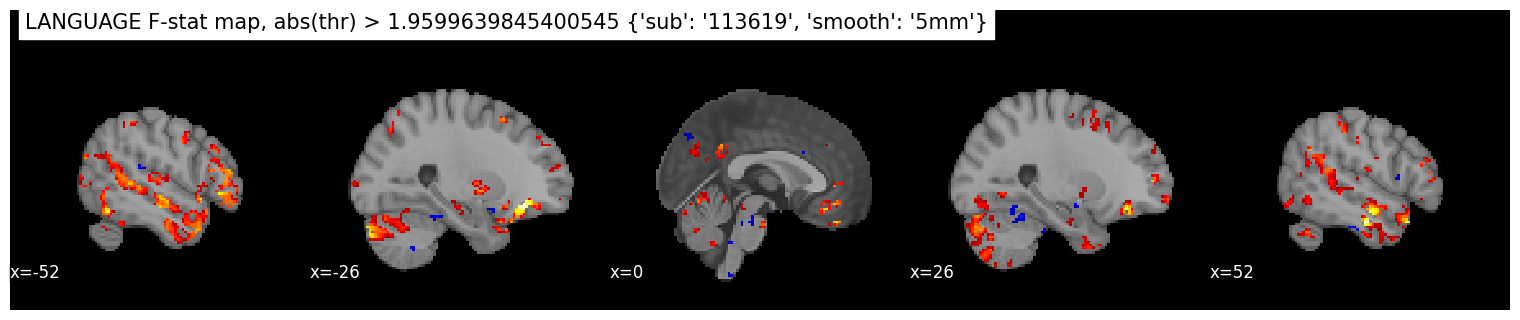

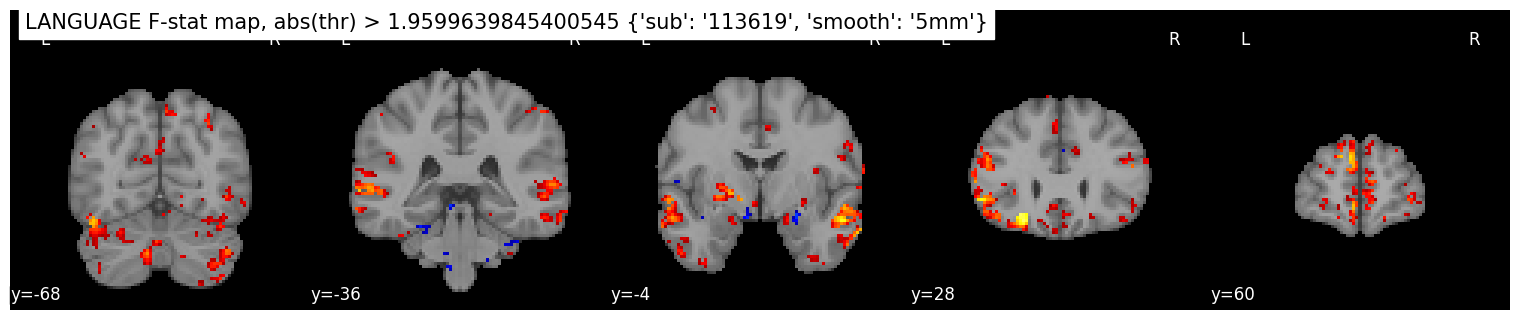

In [25]:
show_task_activation(subject, "LANGUAGE", acquisition, smoothing=5, plot_designmatrix=True, cluster_size=10, fdr_rate=0.05)

/media/miplab-nas2/HCP-Data/HCP_100unrelated_TaskParadigms/113619_Regressor_tfMRI_LANGUAGE_RL.mat
/media/RCPNAS/Data2/CS-433-ML4S/data/events/113619_LANGUAGE_RL_event.csv


onset  duration     trial_type
0    0.00     25.20  condition_2_0
1   27.36     11.52  condition_1_1
2   39.60     24.48  condition_1_2
3   66.24     48.24  condition_2_3
4  115.20     20.88  condition_2_4
5  138.24     12.24  condition_1_5
6  151.20     24.48  condition_1_6
7  177.84     25.20  condition_1_7
8  203.76     12.96  condition_1_8
9  217.44     12.24  condition_1_9

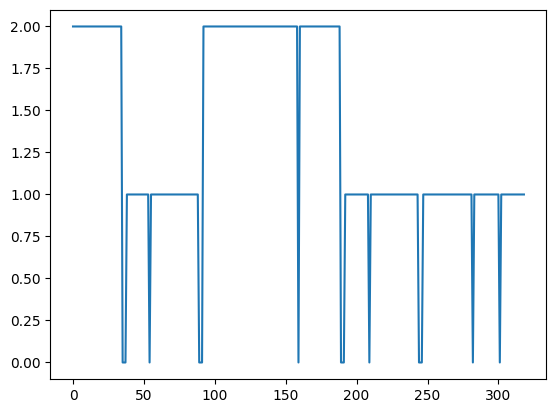

In [26]:
create_events_df(subject, "LANGUAGE", acquisition, plot_regressors=True)

selecting subject gray matter mask
/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/anat/113619_gm_mask.nii.gz
concatenating volumes for task LANGUAGE
/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/func/113619_LANGUAGE_RL_smooth-6mm_fMRIvols.nii.gz
files 113619_LANGUAGE_RL_smooth-6mm_fMRIvols.nii.gz already exists, skipping processing
processing event conditions
/media/miplab-nas2/HCP-Data/HCP_100unrelated_TaskParadigms/113619_Regressor_tfMRI_LANGUAGE_RL.mat
/media/RCPNAS/Data2/CS-433-ML4S/data/events/113619_LANGUAGE_RL_event.csv
fitting GLM for task LANGUAGE


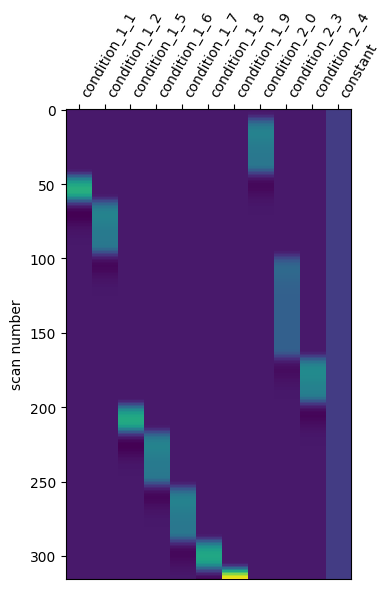

computing fmap


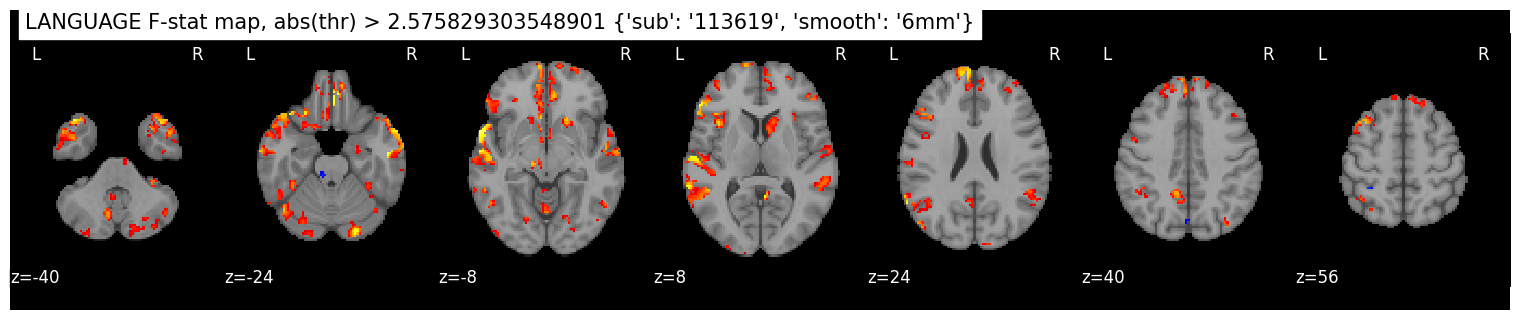

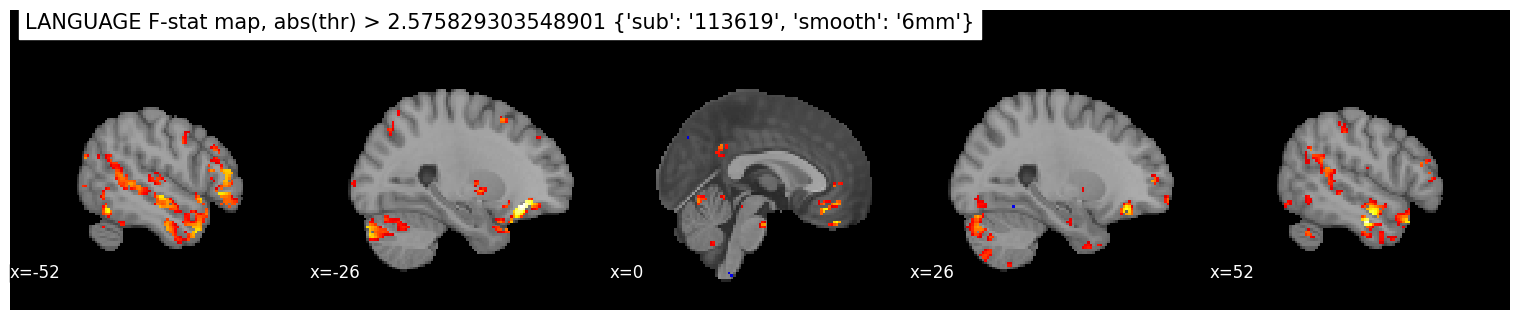

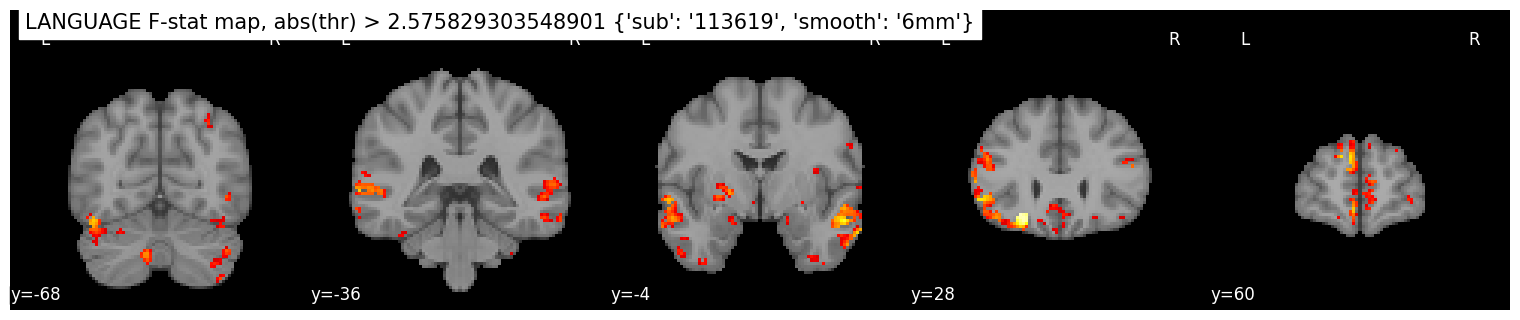

In [27]:
show_task_activation(subject, "LANGUAGE", acquisition, smoothing=6, plot_designmatrix=True, cluster_size=10)

/media/miplab-nas2/HCP-Data/HCP_100unrelated_TaskParadigms/113619_Regressor_tfMRI_SOCIAL_RL.mat
/media/RCPNAS/Data2/CS-433-ML4S/data/events/113619_SOCIAL_RL_event.csv


onset  duration     trial_type
0    7.92     22.32  condition_1_0
1   45.36     22.32  condition_2_1
2   83.52     22.32  condition_2_2
3  121.68     22.32  condition_1_3
4  159.84     22.32  condition_2_4

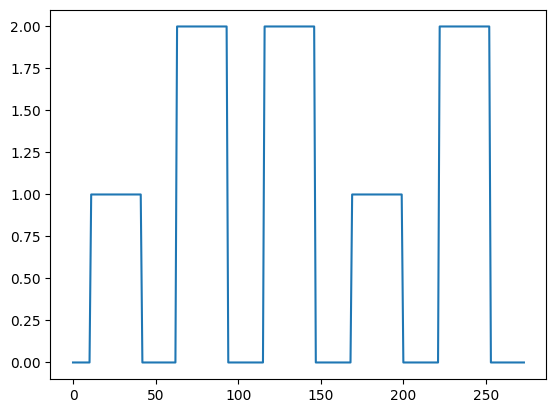

In [28]:
create_events_df(subject, "SOCIAL", acquisition, plot_regressors=True)

selecting subject gray matter mask
/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/anat/113619_gm_mask.nii.gz
concatenating volumes for task SOCIAL
/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/func/113619_SOCIAL_RL_smooth-5mm_fMRIvols.nii.gz
files 113619_SOCIAL_RL_smooth-5mm_fMRIvols.nii.gz already exists, skipping processing
processing event conditions
/media/miplab-nas2/HCP-Data/HCP_100unrelated_TaskParadigms/113619_Regressor_tfMRI_SOCIAL_RL.mat
/media/RCPNAS/Data2/CS-433-ML4S/data/events/113619_SOCIAL_RL_event.csv
fitting GLM for task SOCIAL


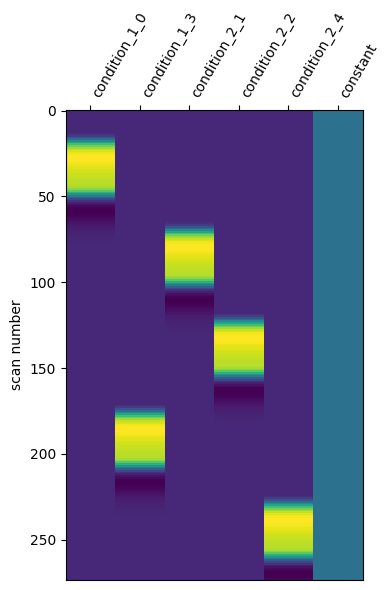

computing fmap


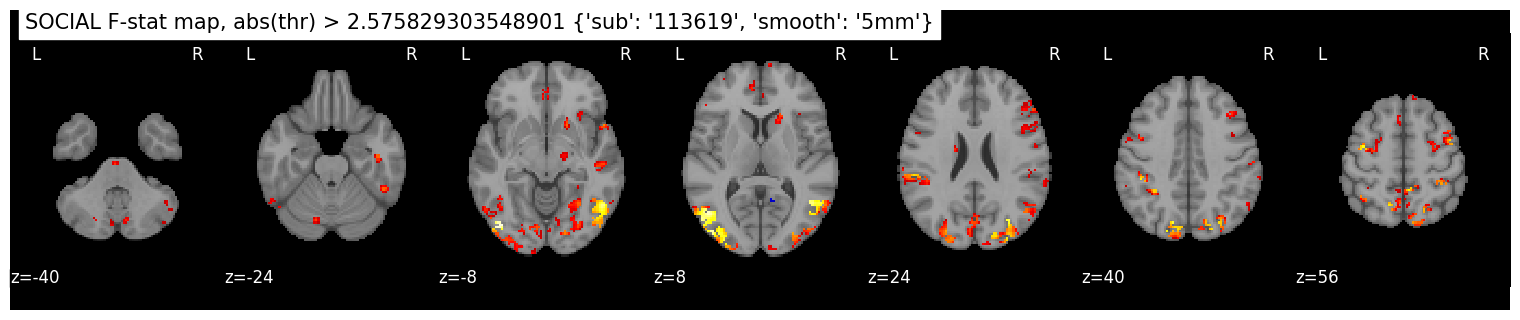

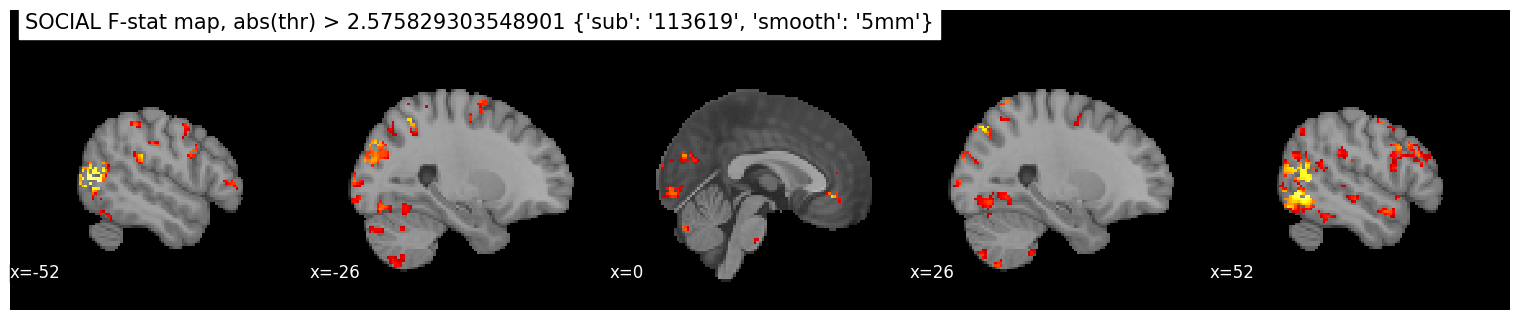

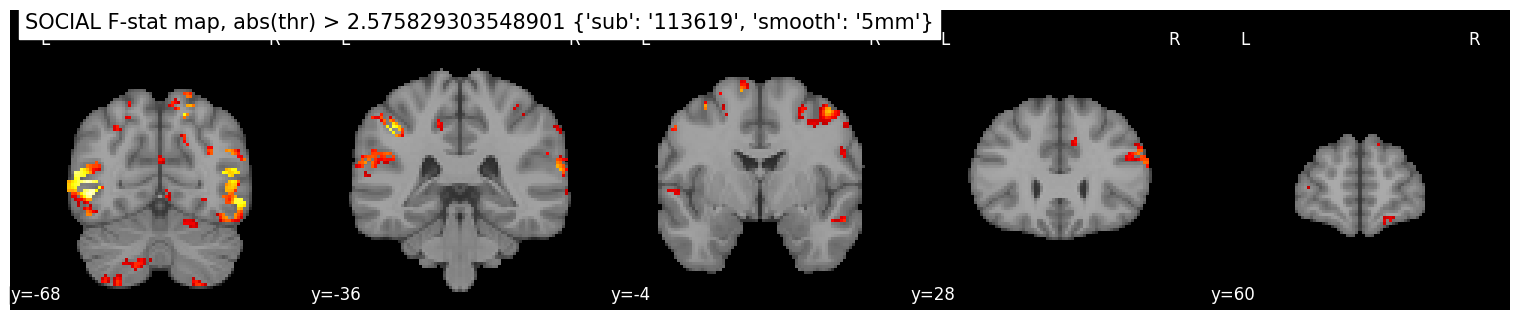

In [29]:
show_task_activation(subject, "SOCIAL", acquisition, smoothing=5, plot_designmatrix=True, cluster_size=10)

# 4 random subjects

In [30]:
subjects = [131722, 414229, 130013, 126325, 130316]

## motor

/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/anat/131722_gm_mask.nii.gz


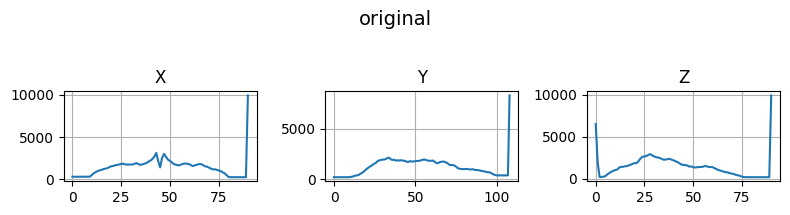

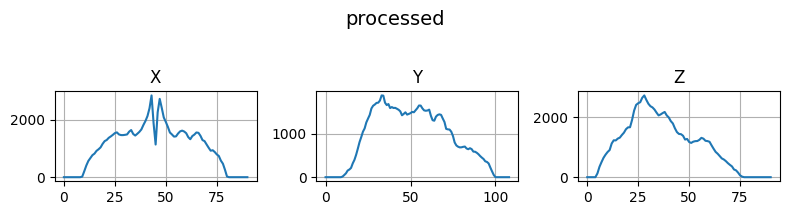

/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/anat/414229_gm_mask.nii.gz


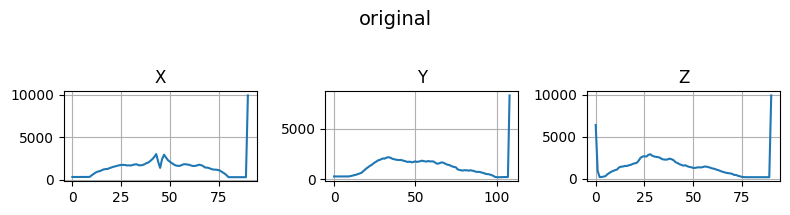

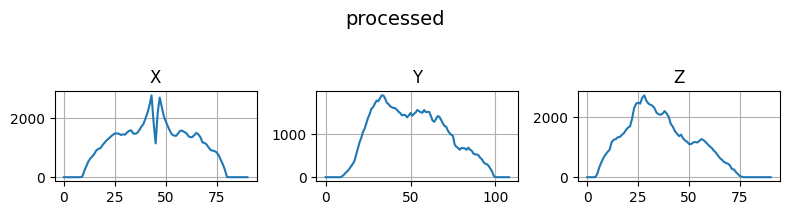

/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/anat/130013_gm_mask.nii.gz


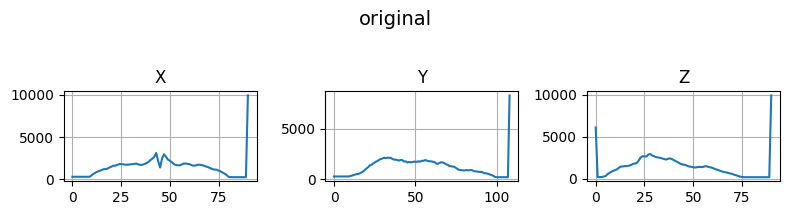

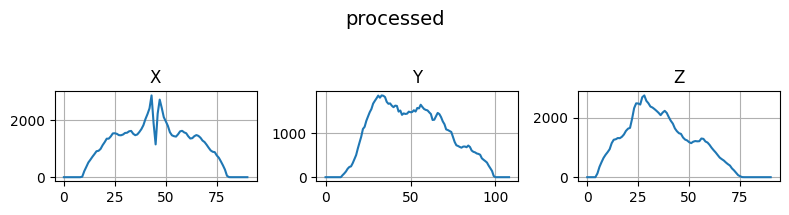

/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/anat/126325_gm_mask.nii.gz


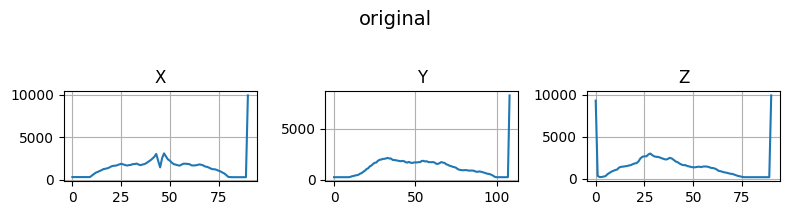

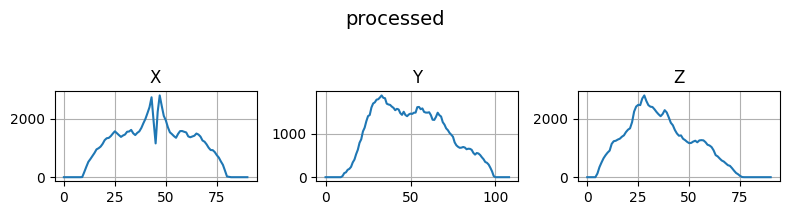

In [31]:
process_gray_matter_mask(anat_dir, "131722", border_size=5, save=True, plot=False)
process_gray_matter_mask(anat_dir, "414229", border_size=5, save=True, plot=False)
process_gray_matter_mask(anat_dir, "130013", border_size=5, save=True, plot=False)
process_gray_matter_mask(anat_dir, "126325", border_size=5, save=True, plot=False)

/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/anat/130316_gm_mask.nii.gz


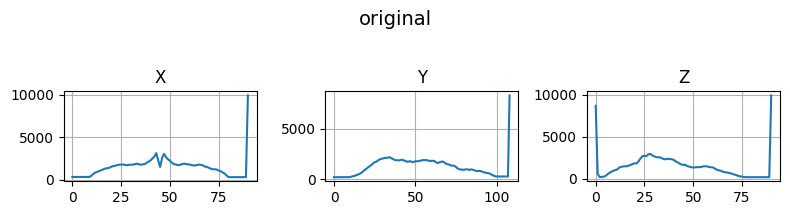

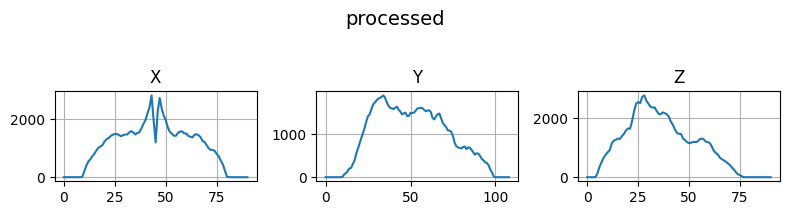

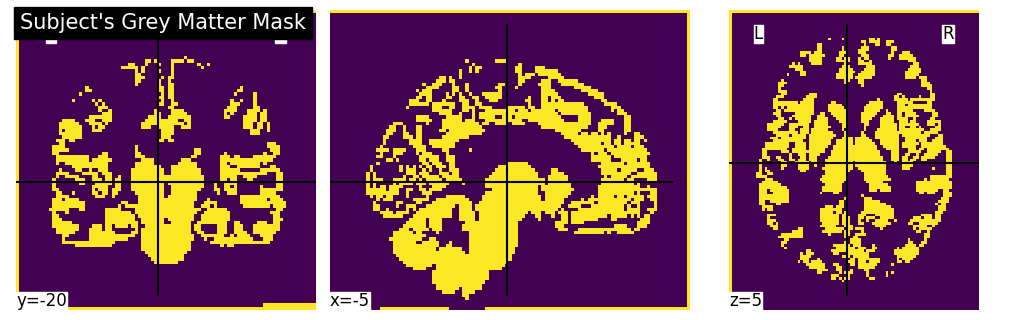

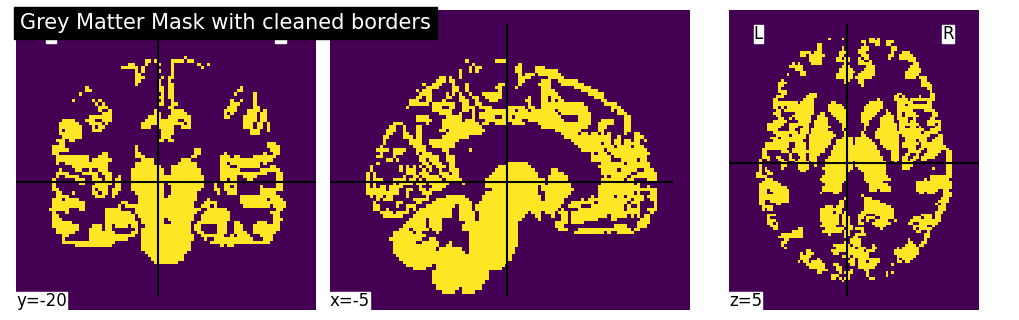

In [32]:
process_gray_matter_mask(anat_dir, "130316", border_size=5, save=False, plot=True)

/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/anat/130316_gm_mask.nii.gz


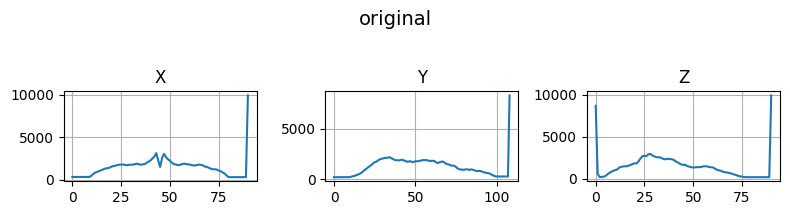

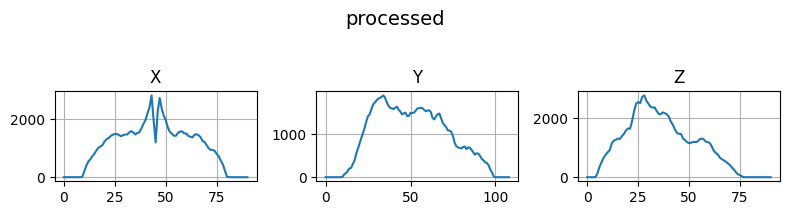

In [33]:
process_gray_matter_mask(anat_dir, "130316", border_size=5, save=True, plot=False)

selecting subject gray matter mask
/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/anat/131722_gm_mask.nii.gz
concatenating volumes for task MOTOR
/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/func/131722_MOTOR_RL_smooth-10mm_fMRIvols.nii.gz
files 131722_MOTOR_RL_smooth-10mm_fMRIvols.nii.gz already exists, skipping processing
processing event conditions
/media/miplab-nas2/HCP-Data/HCP_100unrelated_TaskParadigms/131722_Regressor_tfMRI_MOTOR_RL.mat
/media/RCPNAS/Data2/CS-433-ML4S/data/events/131722_MOTOR_RL_event.csv
fitting GLM for task MOTOR
computing fmap


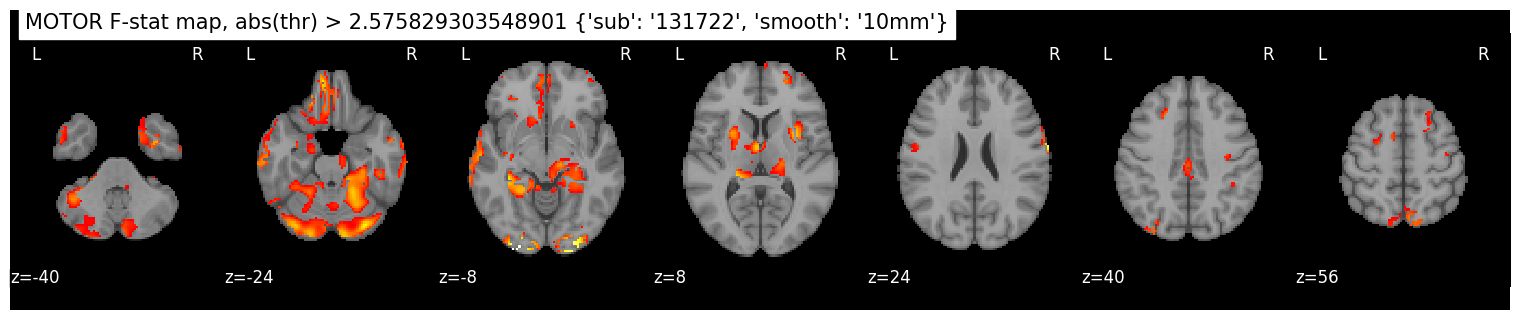

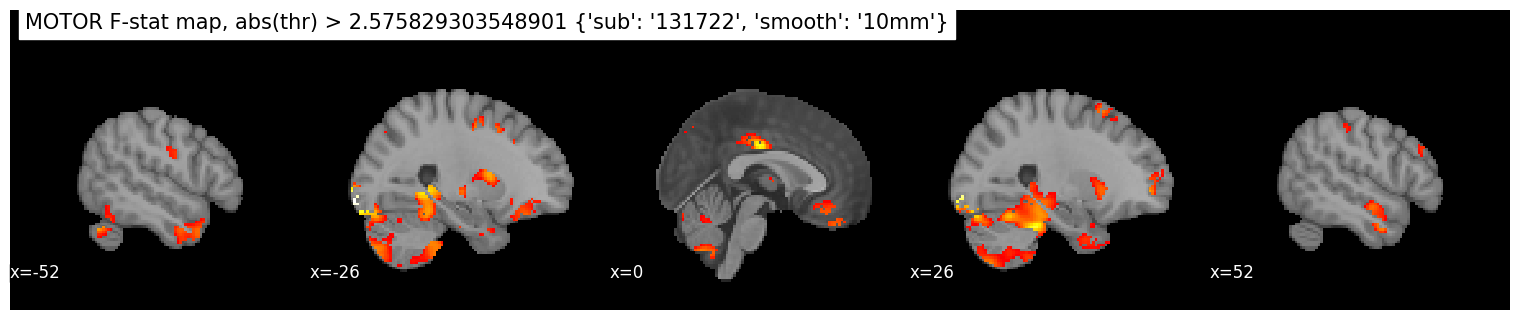

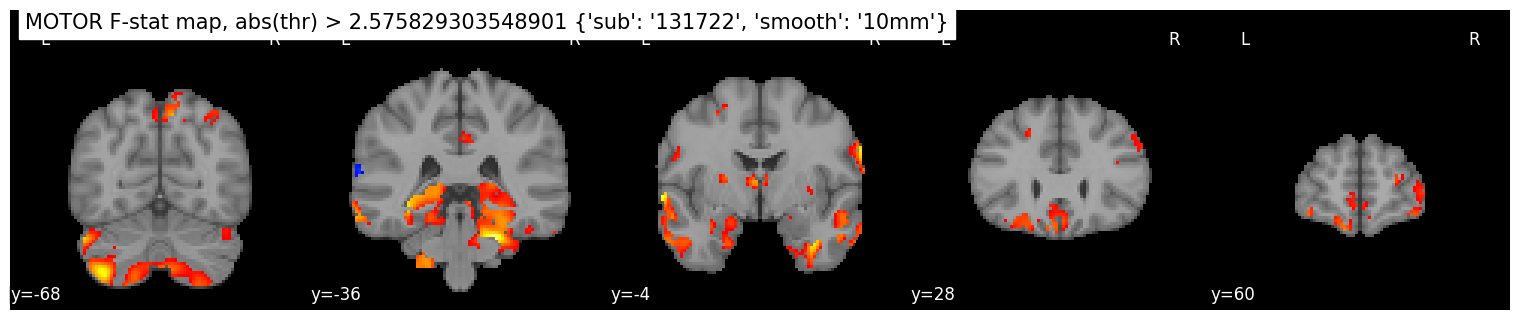

selecting subject gray matter mask
/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/anat/414229_gm_mask.nii.gz
concatenating volumes for task MOTOR
/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/func/414229_MOTOR_RL_smooth-10mm_fMRIvols.nii.gz
files 414229_MOTOR_RL_smooth-10mm_fMRIvols.nii.gz already exists, skipping processing
processing event conditions
/media/miplab-nas2/HCP-Data/HCP_100unrelated_TaskParadigms/414229_Regressor_tfMRI_MOTOR_RL.mat
/media/RCPNAS/Data2/CS-433-ML4S/data/events/414229_MOTOR_RL_event.csv
fitting GLM for task MOTOR
computing fmap


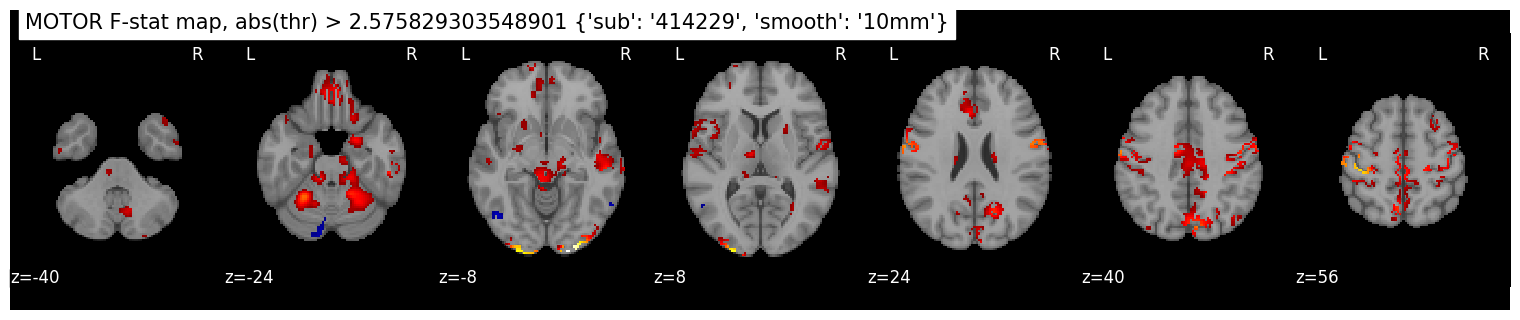

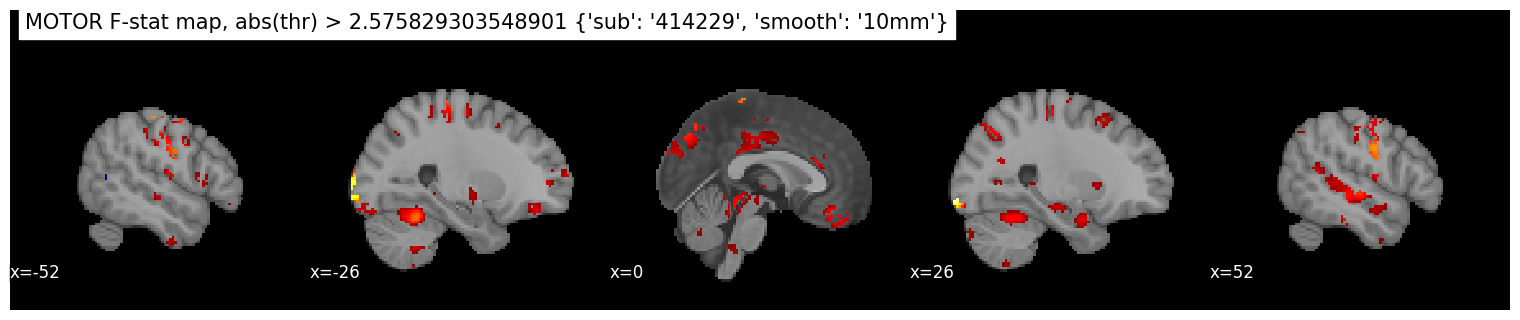

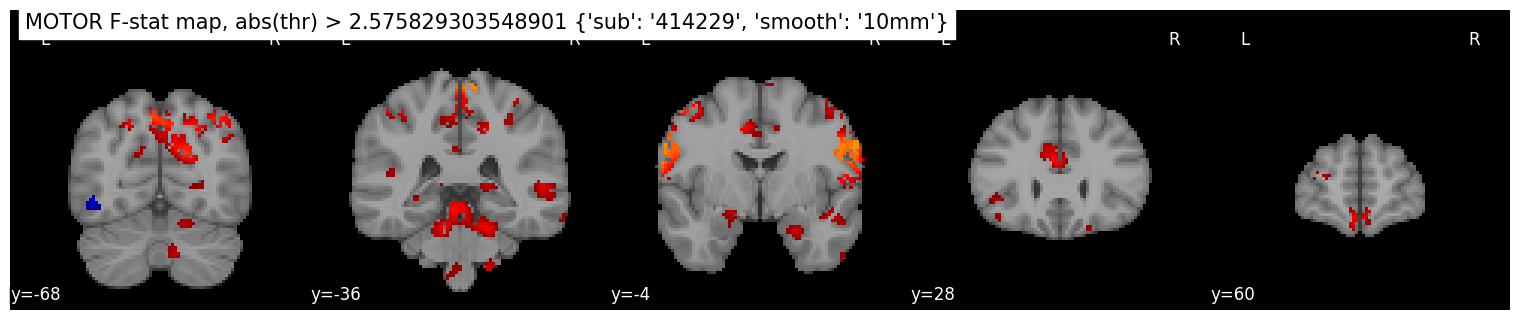

selecting subject gray matter mask
/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/anat/130013_gm_mask.nii.gz
concatenating volumes for task MOTOR
/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/func/130013_MOTOR_RL_smooth-10mm_fMRIvols.nii.gz
files 130013_MOTOR_RL_smooth-10mm_fMRIvols.nii.gz already exists, skipping processing
processing event conditions
/media/miplab-nas2/HCP-Data/HCP_100unrelated_TaskParadigms/130013_Regressor_tfMRI_MOTOR_RL.mat
/media/RCPNAS/Data2/CS-433-ML4S/data/events/130013_MOTOR_RL_event.csv
fitting GLM for task MOTOR
computing fmap


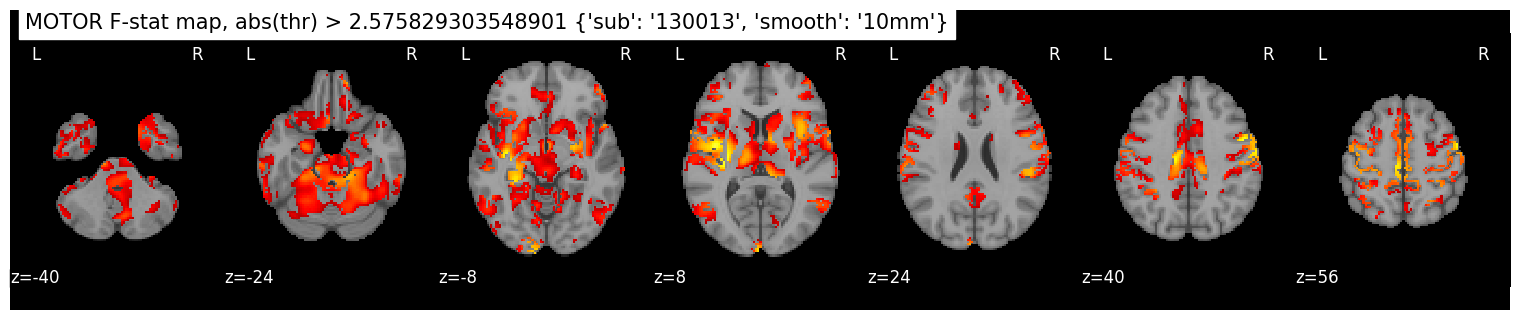

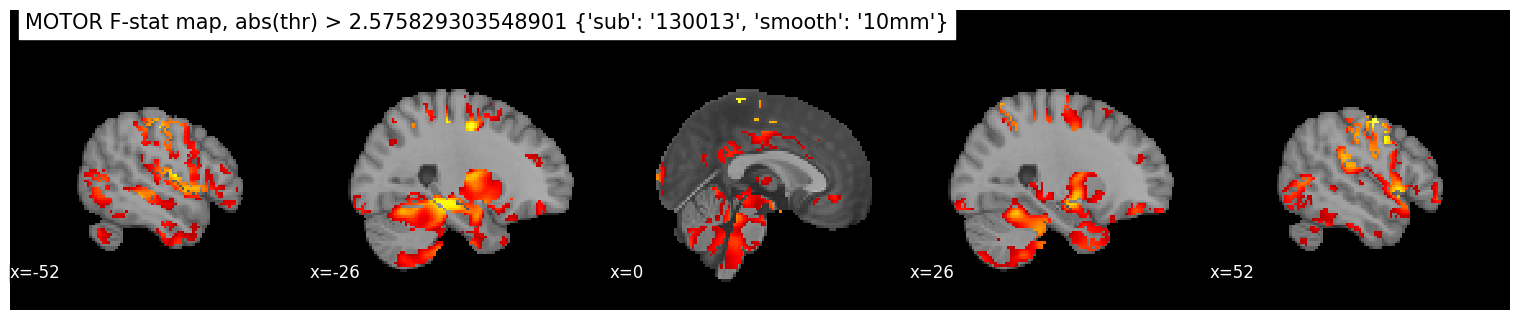

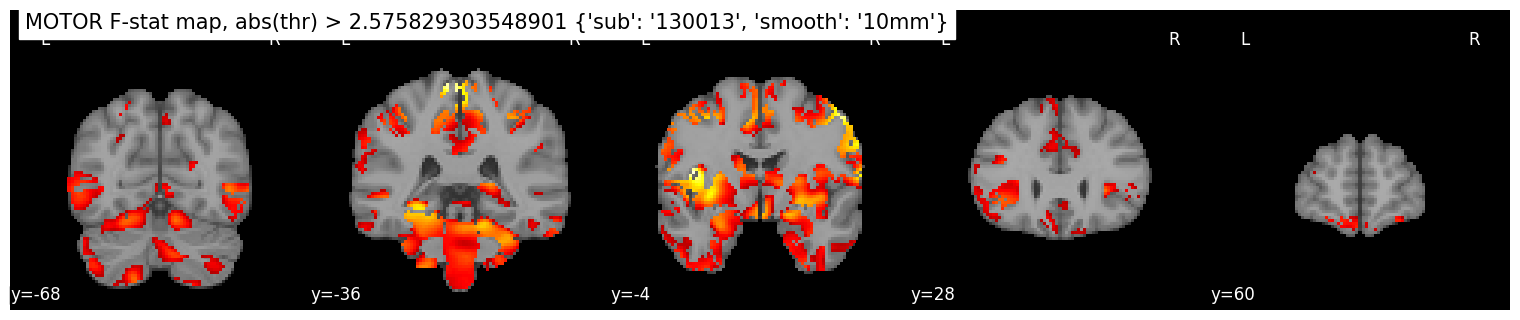

selecting subject gray matter mask
/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/anat/126325_gm_mask.nii.gz
concatenating volumes for task MOTOR
/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/func/126325_MOTOR_RL_smooth-10mm_fMRIvols.nii.gz
files 126325_MOTOR_RL_smooth-10mm_fMRIvols.nii.gz already exists, skipping processing
processing event conditions
/media/miplab-nas2/HCP-Data/HCP_100unrelated_TaskParadigms/126325_Regressor_tfMRI_MOTOR_RL.mat
/media/RCPNAS/Data2/CS-433-ML4S/data/events/126325_MOTOR_RL_event.csv
fitting GLM for task MOTOR
computing fmap


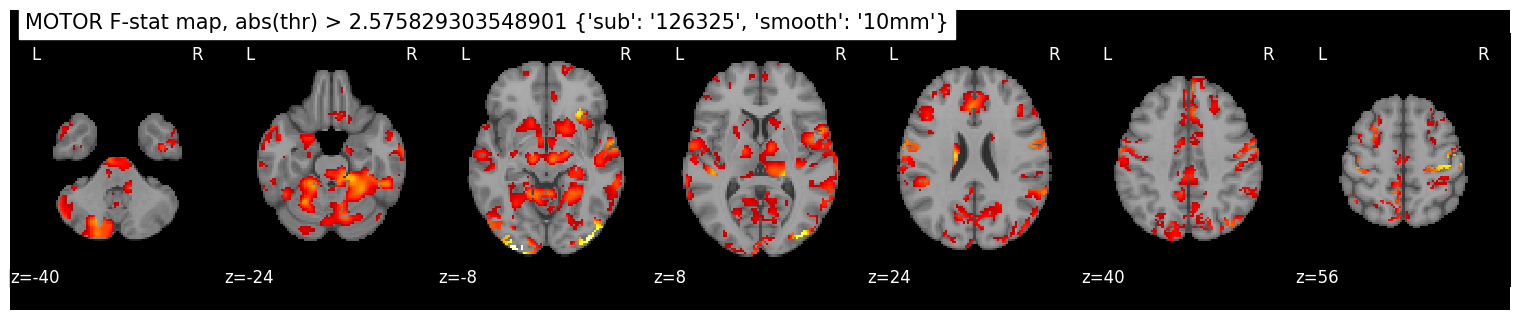

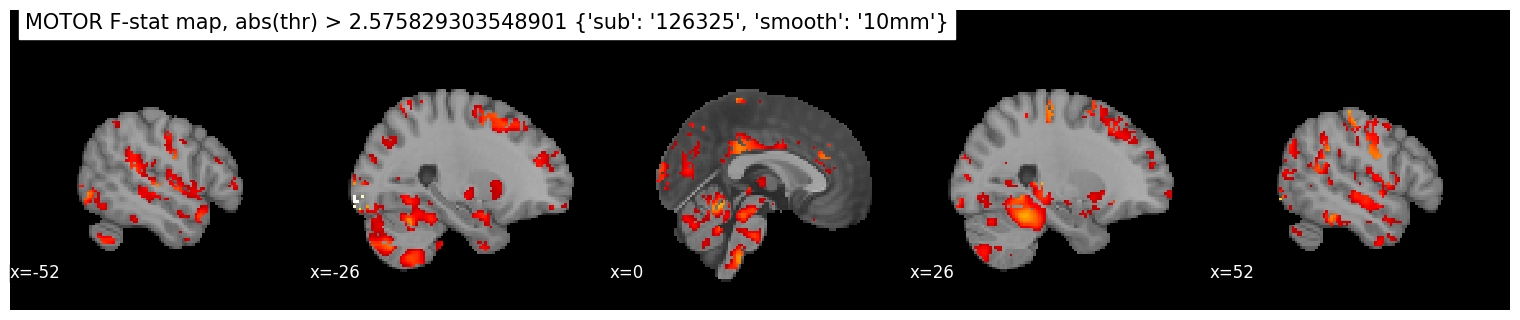

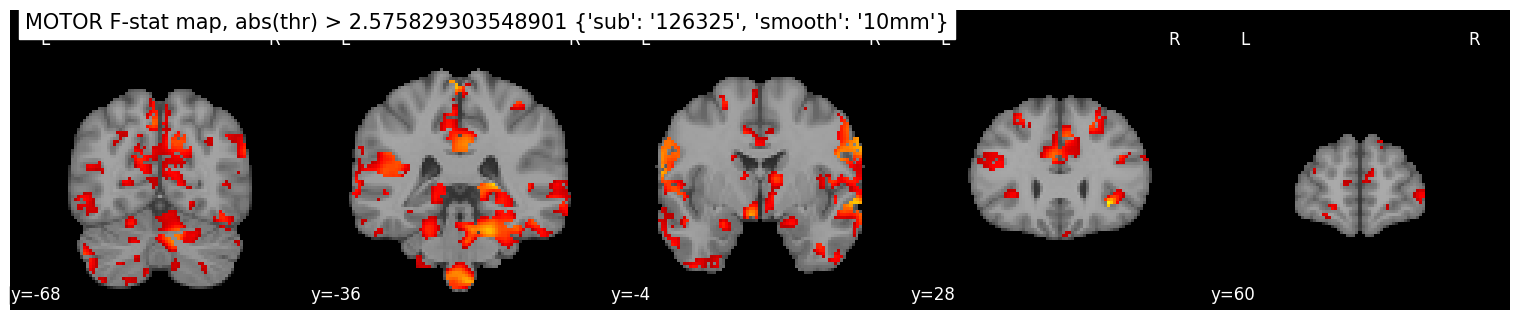

selecting subject gray matter mask
/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/anat/130316_gm_mask.nii.gz
concatenating volumes for task MOTOR
/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/func/130316_MOTOR_RL_smooth-10mm_fMRIvols.nii.gz
files 130316_MOTOR_RL_smooth-10mm_fMRIvols.nii.gz already exists, skipping processing
processing event conditions
/media/miplab-nas2/HCP-Data/HCP_100unrelated_TaskParadigms/130316_Regressor_tfMRI_MOTOR_RL.mat
/media/RCPNAS/Data2/CS-433-ML4S/data/events/130316_MOTOR_RL_event.csv
fitting GLM for task MOTOR
computing fmap


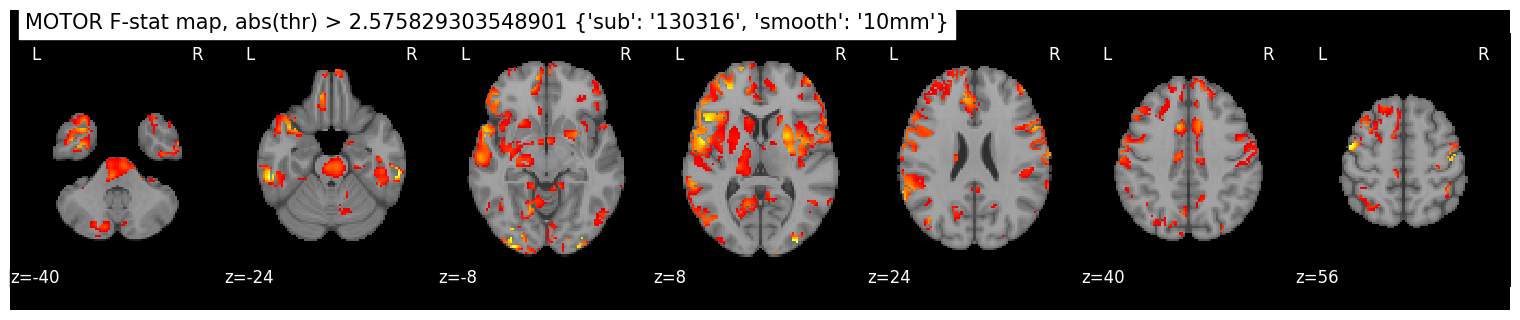

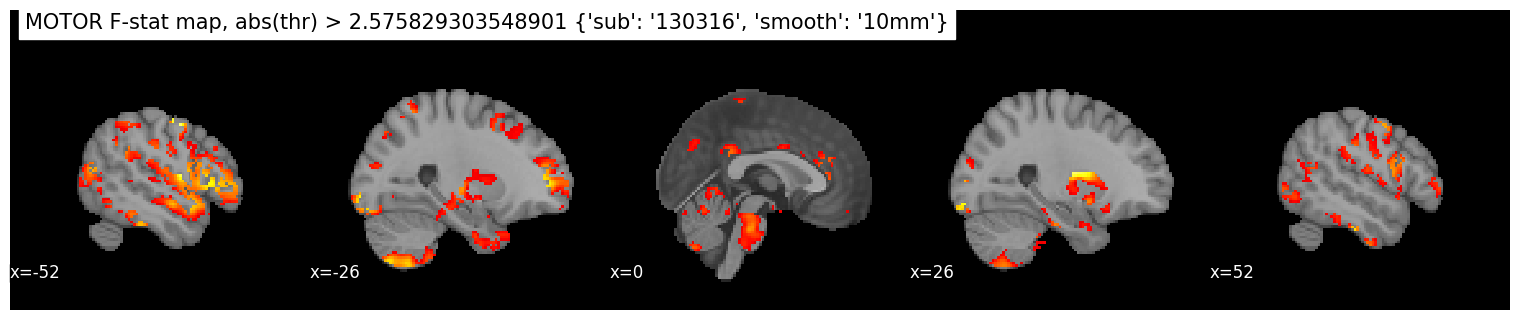

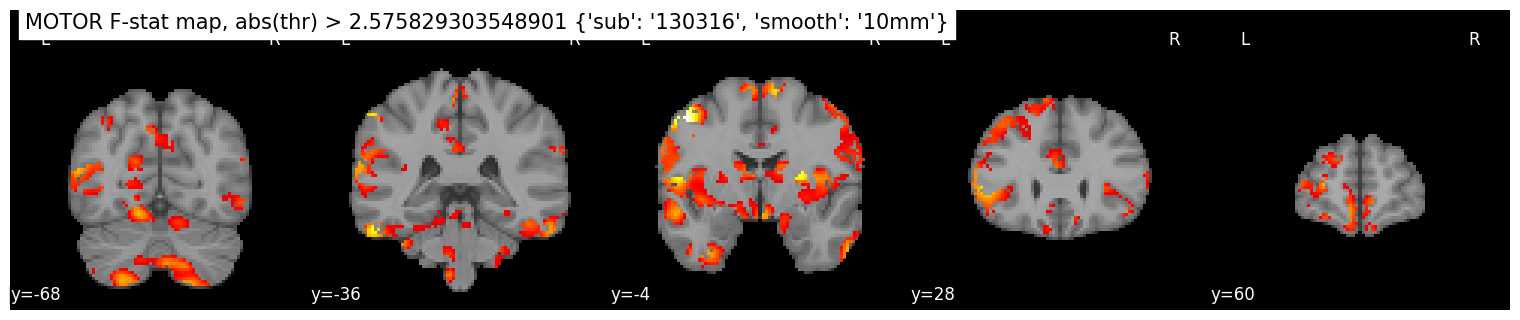

In [34]:
for subject in subjects:
    show_task_activation(f"{subject}", "MOTOR", acquisition, smoothing=10, plot_designmatrix=False, cluster_size=15, plot_glass=False)

selecting subject gray matter mask
/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/anat/131722_gm_mask.nii.gz
concatenating volumes for task LANGUAGE
/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/func/131722_LANGUAGE_RL_smooth-10mm_fMRIvols.nii.gz
files 131722_LANGUAGE_RL_smooth-10mm_fMRIvols.nii.gz already exists, skipping processing
processing event conditions
/media/miplab-nas2/HCP-Data/HCP_100unrelated_TaskParadigms/131722_Regressor_tfMRI_LANGUAGE_RL.mat
/media/RCPNAS/Data2/CS-433-ML4S/data/events/131722_LANGUAGE_RL_event.csv
fitting GLM for task LANGUAGE
computing fmap


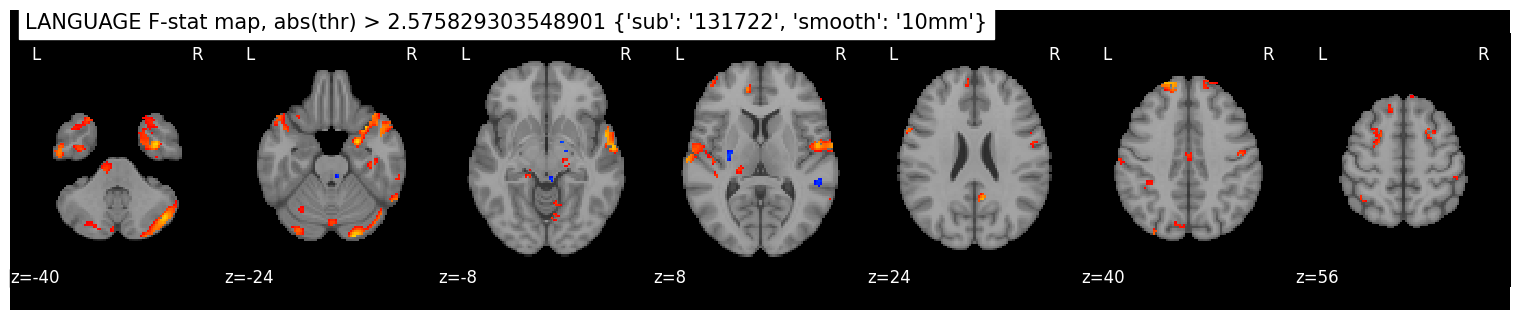

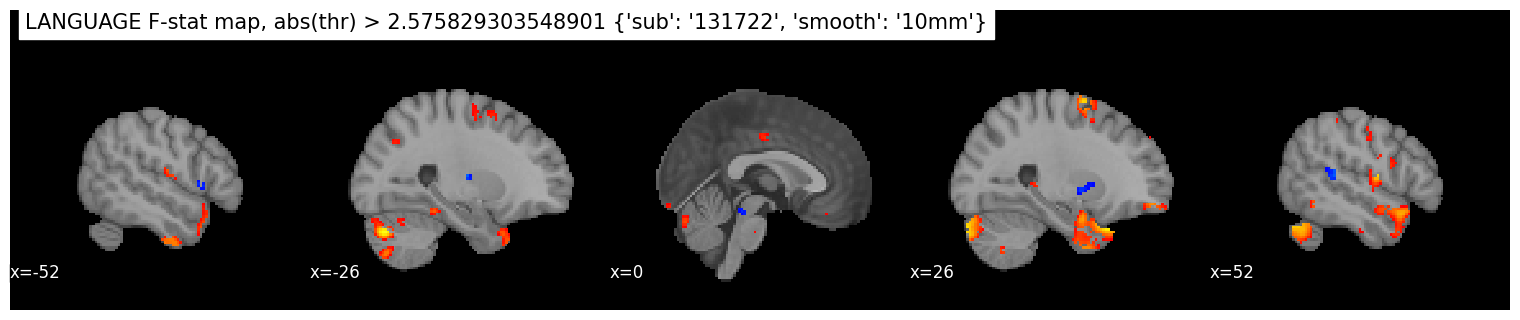

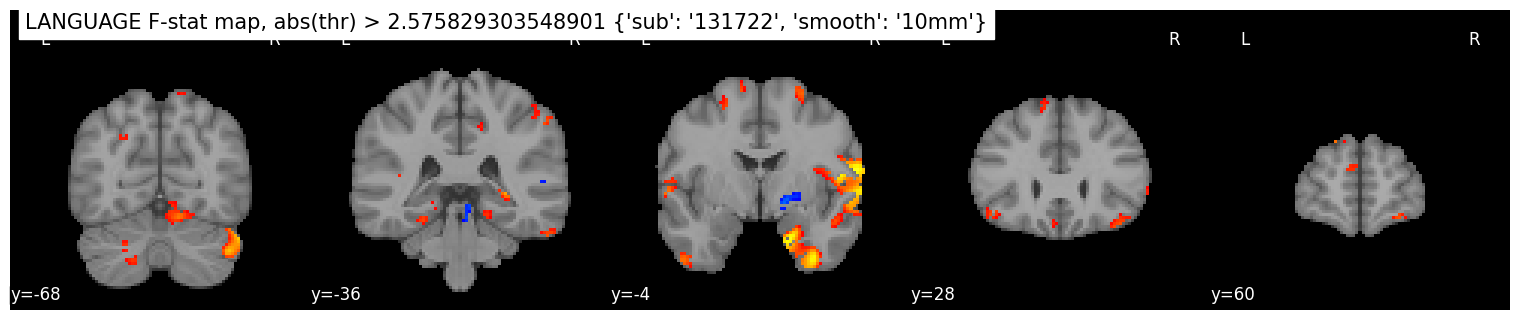

selecting subject gray matter mask
/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/anat/414229_gm_mask.nii.gz
concatenating volumes for task LANGUAGE
/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/func/414229_LANGUAGE_RL_smooth-10mm_fMRIvols.nii.gz
files 414229_LANGUAGE_RL_smooth-10mm_fMRIvols.nii.gz already exists, skipping processing
processing event conditions
/media/miplab-nas2/HCP-Data/HCP_100unrelated_TaskParadigms/414229_Regressor_tfMRI_LANGUAGE_RL.mat
/media/RCPNAS/Data2/CS-433-ML4S/data/events/414229_LANGUAGE_RL_event.csv
fitting GLM for task LANGUAGE
computing fmap


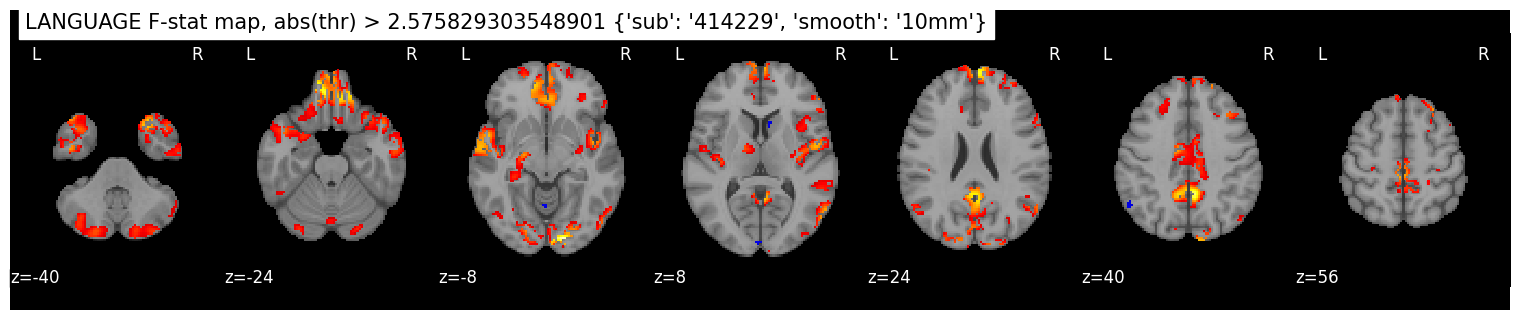

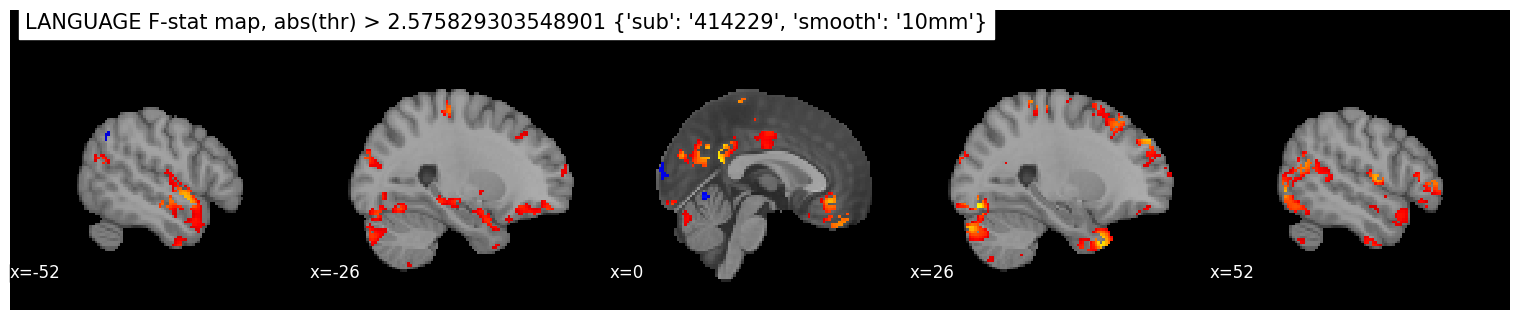

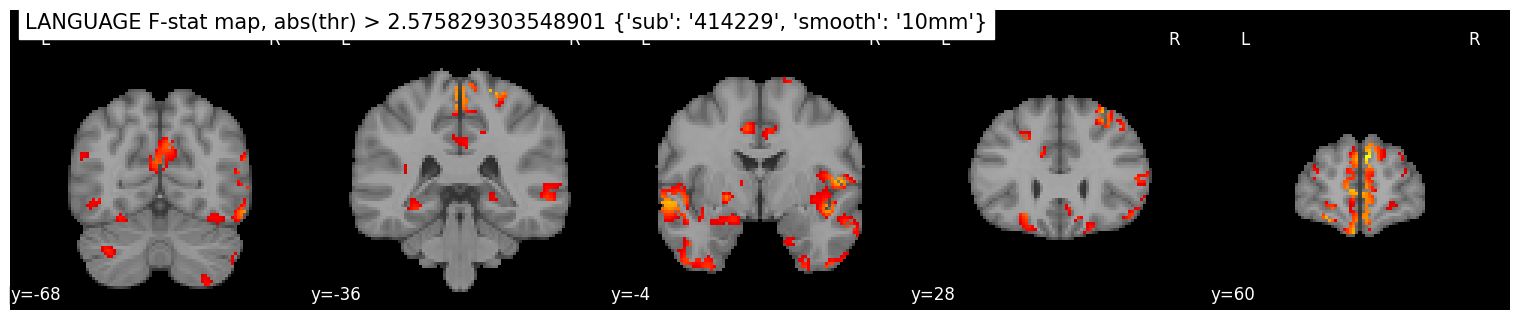

selecting subject gray matter mask
/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/anat/130013_gm_mask.nii.gz
concatenating volumes for task LANGUAGE
/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/func/130013_LANGUAGE_RL_smooth-10mm_fMRIvols.nii.gz
files 130013_LANGUAGE_RL_smooth-10mm_fMRIvols.nii.gz already exists, skipping processing
processing event conditions
/media/miplab-nas2/HCP-Data/HCP_100unrelated_TaskParadigms/130013_Regressor_tfMRI_LANGUAGE_RL.mat
/media/RCPNAS/Data2/CS-433-ML4S/data/events/130013_LANGUAGE_RL_event.csv
fitting GLM for task LANGUAGE
computing fmap


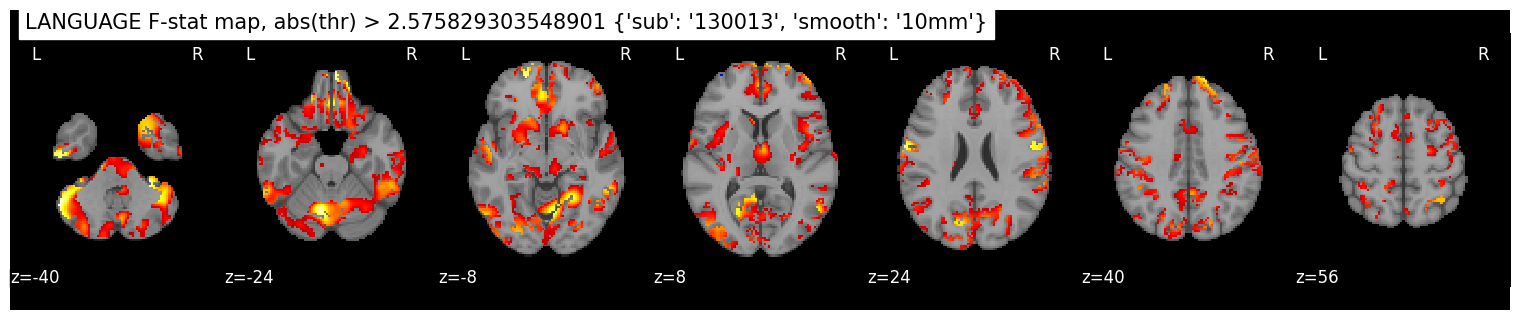

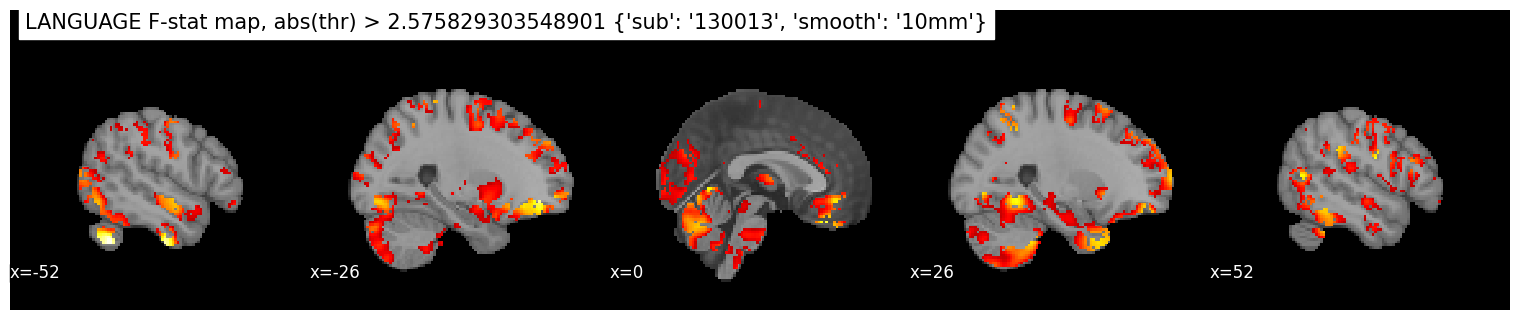

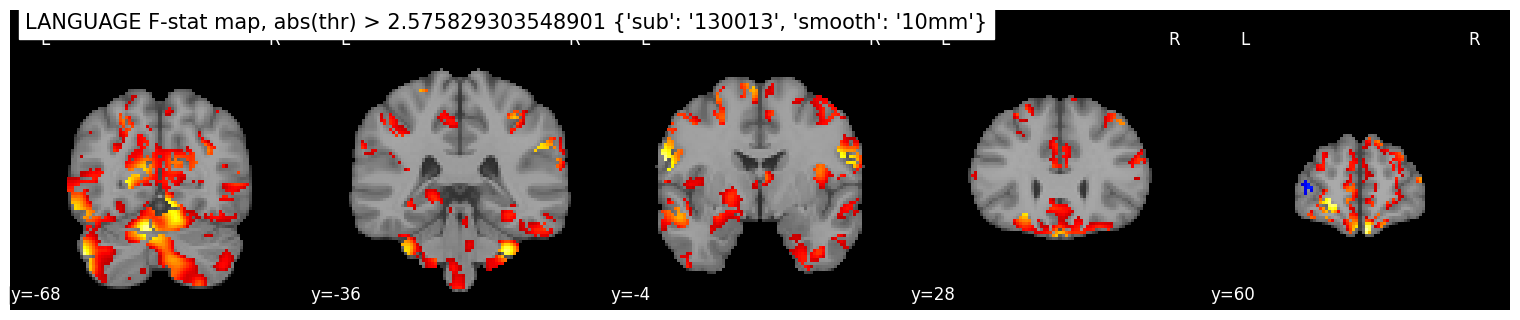

selecting subject gray matter mask
/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/anat/126325_gm_mask.nii.gz
concatenating volumes for task LANGUAGE
/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/func/126325_LANGUAGE_RL_smooth-10mm_fMRIvols.nii.gz
files 126325_LANGUAGE_RL_smooth-10mm_fMRIvols.nii.gz already exists, skipping processing
processing event conditions
/media/miplab-nas2/HCP-Data/HCP_100unrelated_TaskParadigms/126325_Regressor_tfMRI_LANGUAGE_RL.mat
/media/RCPNAS/Data2/CS-433-ML4S/data/events/126325_LANGUAGE_RL_event.csv
fitting GLM for task LANGUAGE
computing fmap


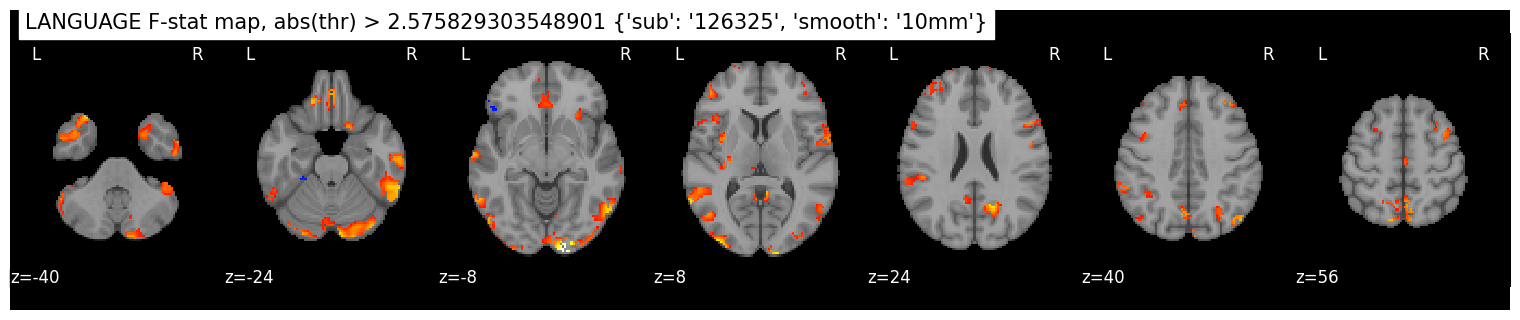

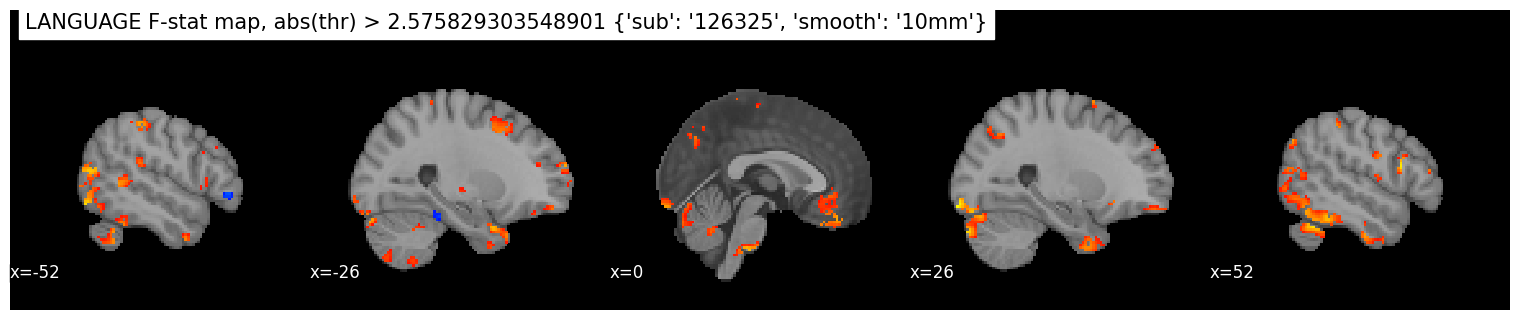

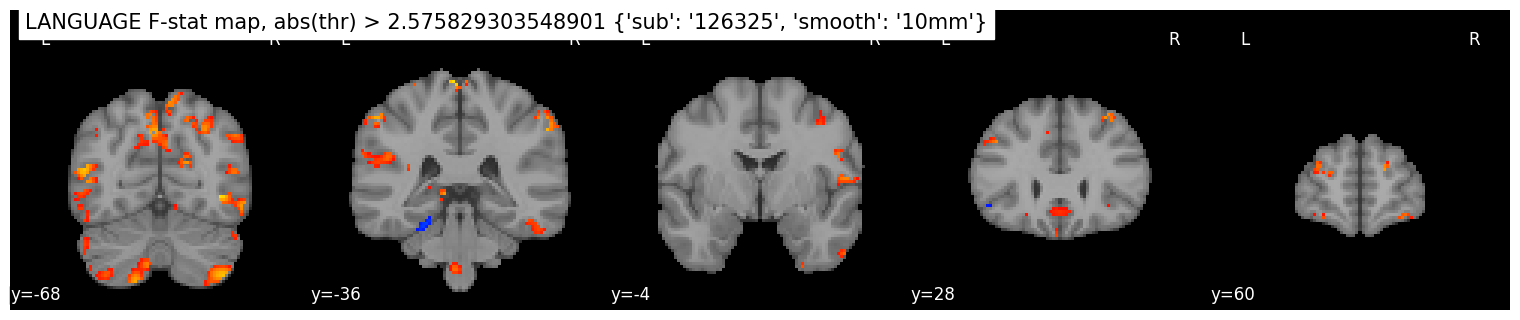

selecting subject gray matter mask
/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/anat/130316_gm_mask.nii.gz
concatenating volumes for task LANGUAGE
/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/func/130316_LANGUAGE_RL_smooth-10mm_fMRIvols.nii.gz
files 130316_LANGUAGE_RL_smooth-10mm_fMRIvols.nii.gz already exists, skipping processing
processing event conditions
/media/miplab-nas2/HCP-Data/HCP_100unrelated_TaskParadigms/130316_Regressor_tfMRI_LANGUAGE_RL.mat
/media/RCPNAS/Data2/CS-433-ML4S/data/events/130316_LANGUAGE_RL_event.csv
fitting GLM for task LANGUAGE
computing fmap


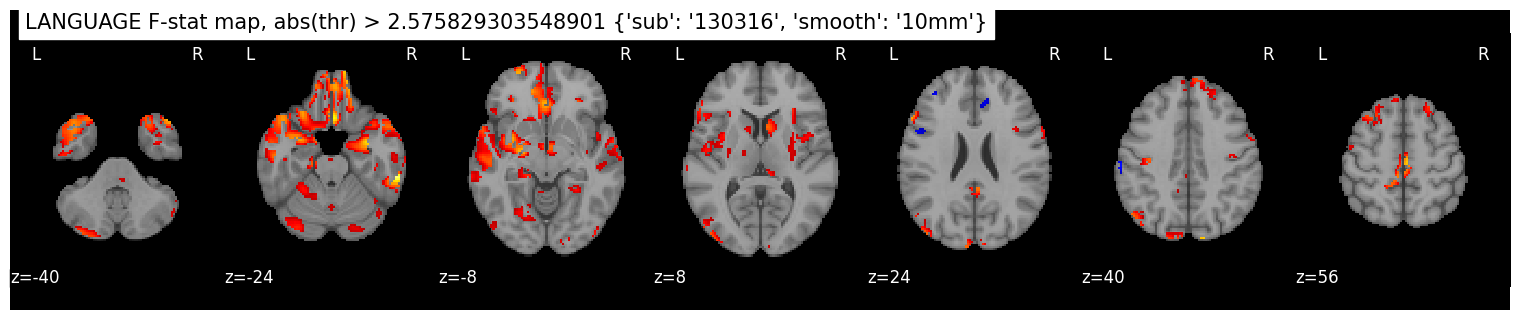

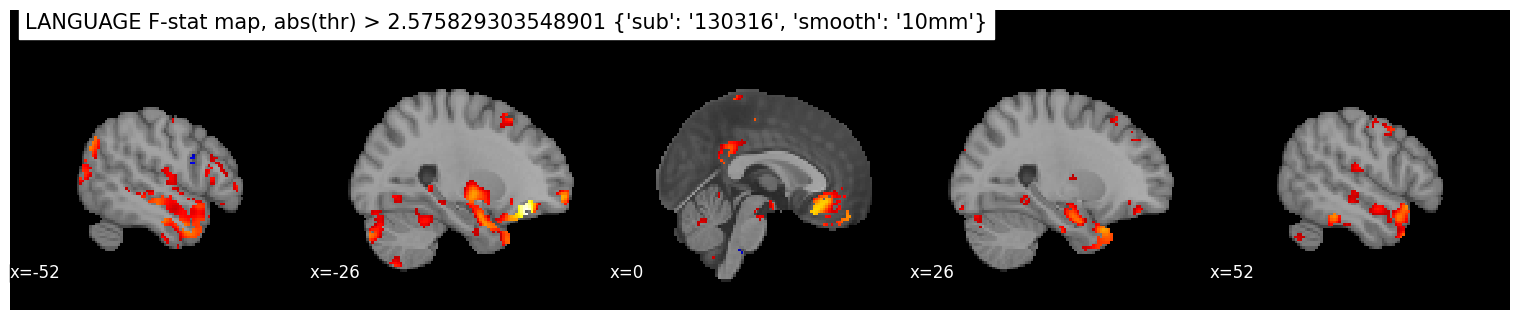

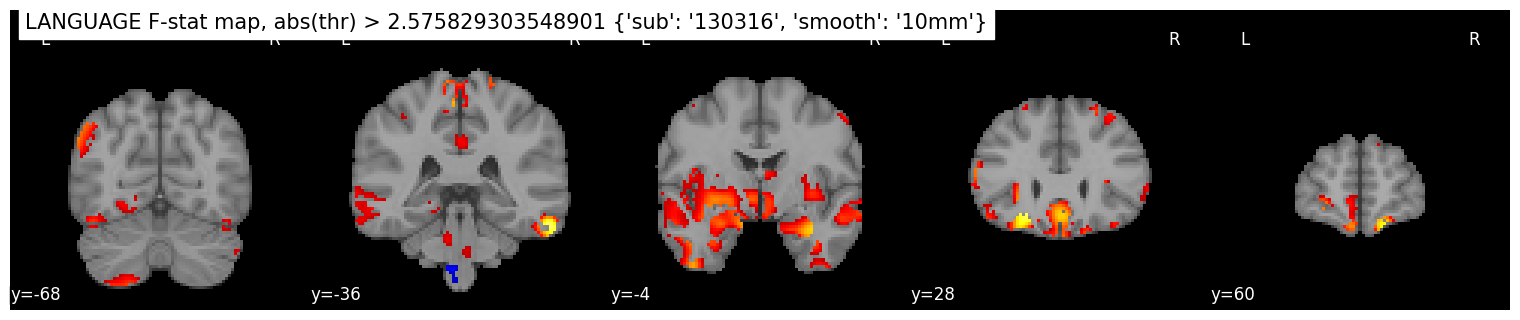

In [35]:
for subject in subjects:
    show_task_activation(f"{subject}", "LANGUAGE", acquisition, smoothing=10, plot_designmatrix=False, cluster_size=15, plot_glass=False)

In [45]:
nilearn.__version__

'0.10.2'

In [38]:
from utils import show_task_activation

selecting subject gray matter mask
/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/anat/127630_gm_mask.nii.gz
concatenating volumes for task MOTOR
/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/func/127630_MOTOR_LR_smooth-5mm_fMRIvols.nii.gz
files 127630_MOTOR_LR_smooth-5mm_fMRIvols.nii.gz already exists, skipping processing
processing event conditions
/media/miplab-nas2/HCP-Data/HCP_100unrelated_TaskParadigms/127630_Regressor_tfMRI_MOTOR_LR.mat
/media/RCPNAS/Data2/CS-433-ML4S/data/events/127630_MOTOR_LR_event.csv
fitting GLM for task MOTOR
computing fmap


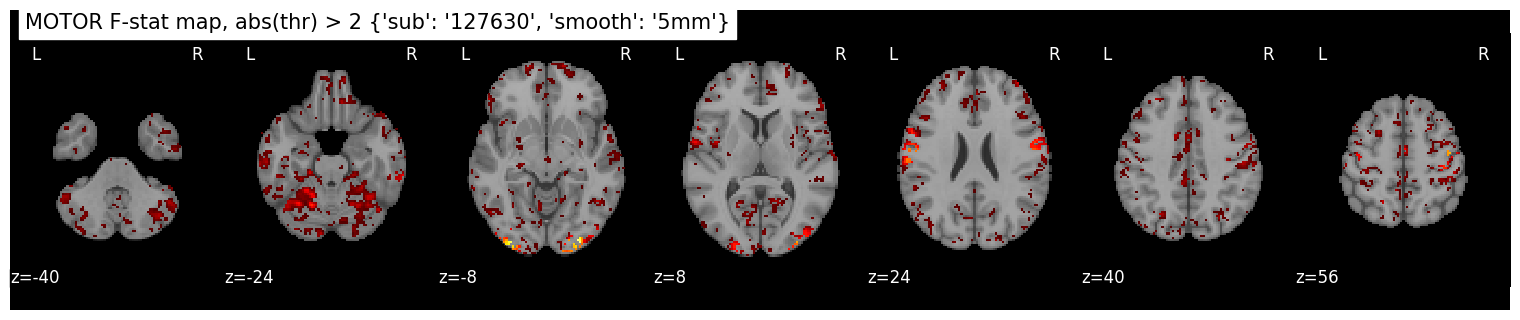

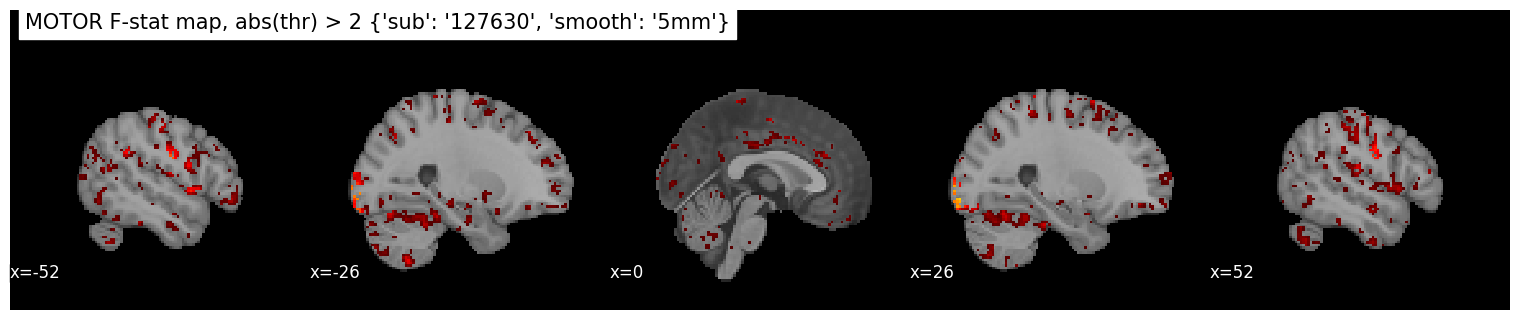

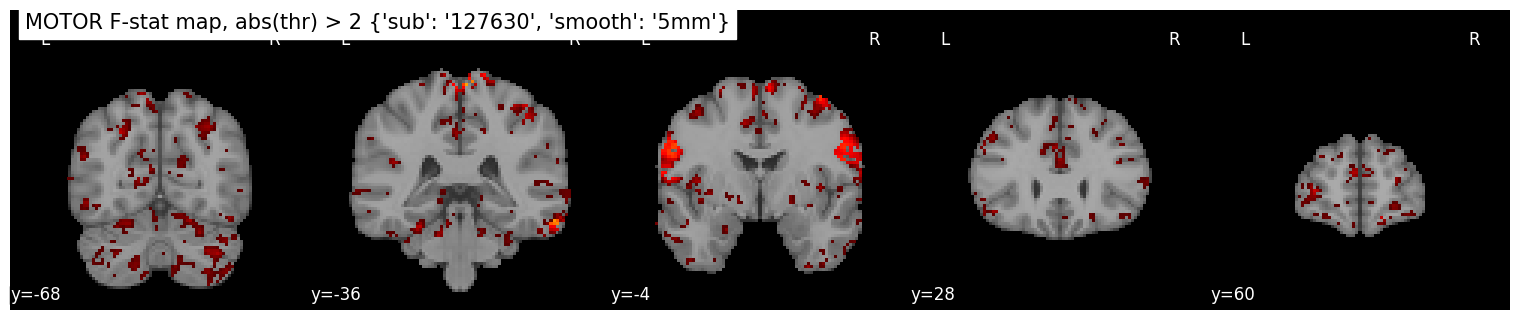

In [43]:
show_task_activation("127630", "MOTOR", "LR", smoothing=10, plot_designmatrix=False, cluster_size=None)

selecting subject gray matter mask
/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/anat/127630_gm_mask.nii.gz
concatenating volumes for task MOTOR
/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/func/127630_MOTOR_RL_smooth-5mm_fMRIvols.nii.gz
files 127630_MOTOR_RL_smooth-5mm_fMRIvols.nii.gz already exists, skipping processing
processing event conditions
/media/miplab-nas2/HCP-Data/HCP_100unrelated_TaskParadigms/127630_Regressor_tfMRI_MOTOR_RL.mat
/media/RCPNAS/Data2/CS-433-ML4S/data/events/127630_MOTOR_RL_event.csv
fitting GLM for task MOTOR
computing fmap


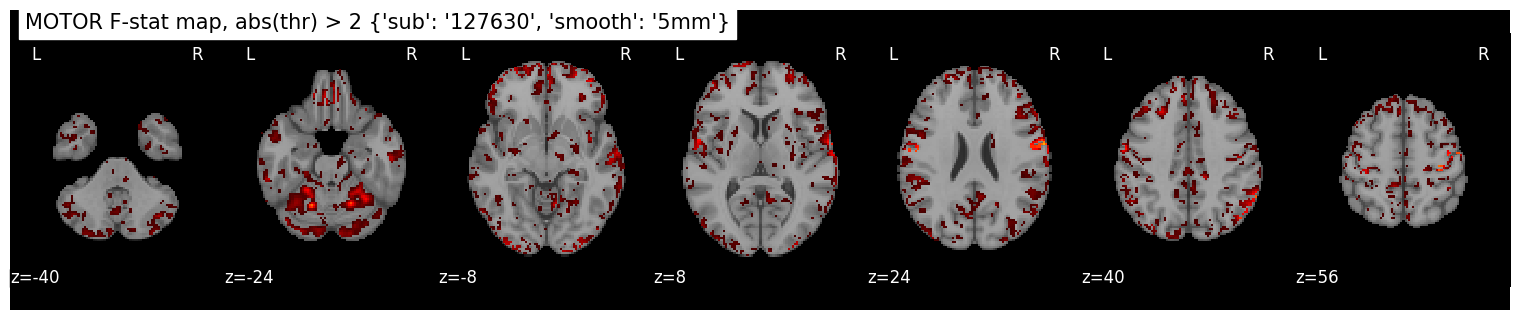

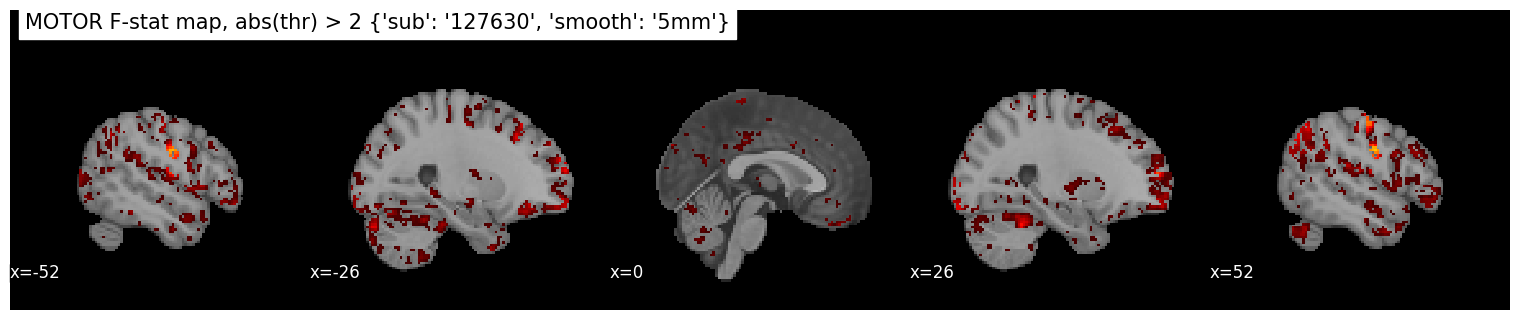

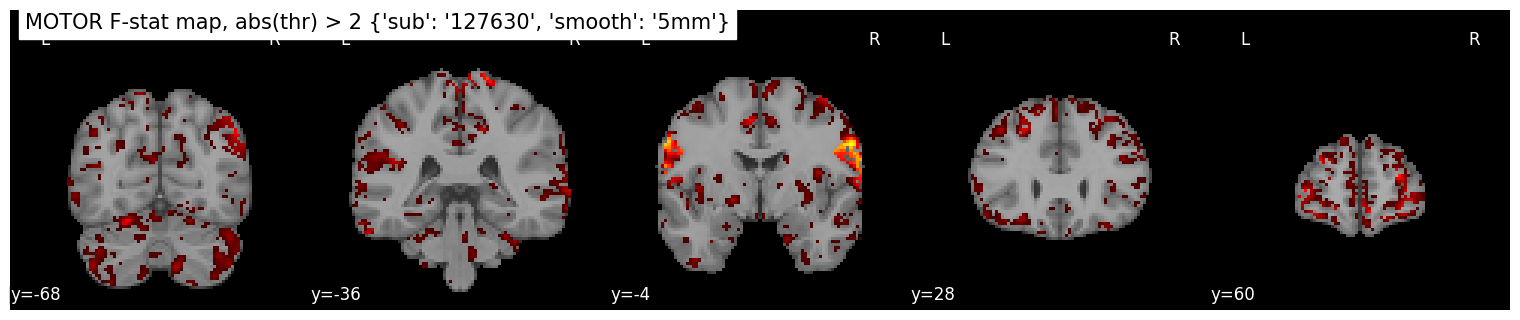

In [44]:
show_task_activation("127630", "MOTOR", "RL", smoothing=10, plot_designmatrix=False, cluster_size=None)

In [ ]:
p

selecting subject gray matter mask
/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/anat/130013_gm_mask.nii.gz
concatenating volumes for task MOTOR
/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/func/130013_MOTOR_LR_smooth-5mm_fMRIvols.nii.gz
processing event conditions
/media/miplab-nas2/HCP-Data/HCP_100unrelated_TaskParadigms/130013_Regressor_tfMRI_MOTOR_LR.mat
/media/RCPNAS/Data2/CS-433-ML4S/data/events/130013_MOTOR_LR_event.csv
fitting GLM for task MOTOR
computing fmap


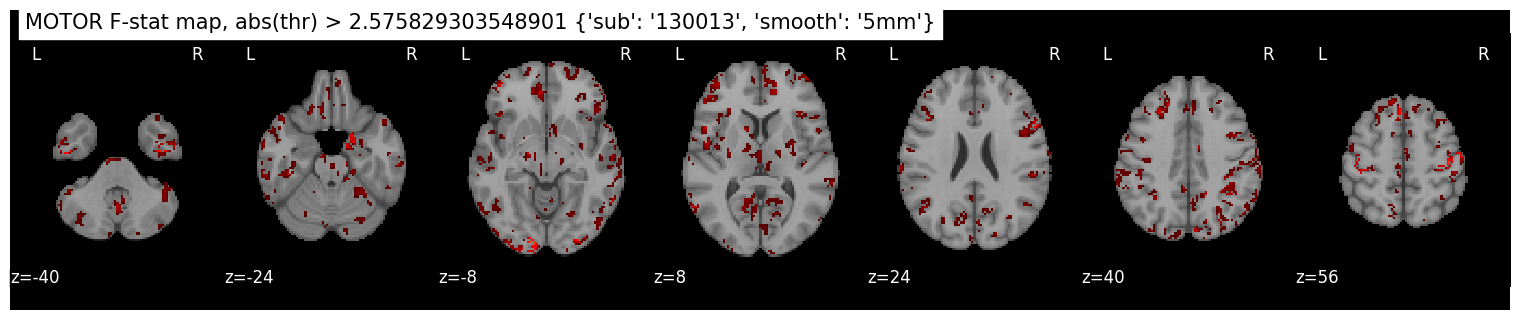

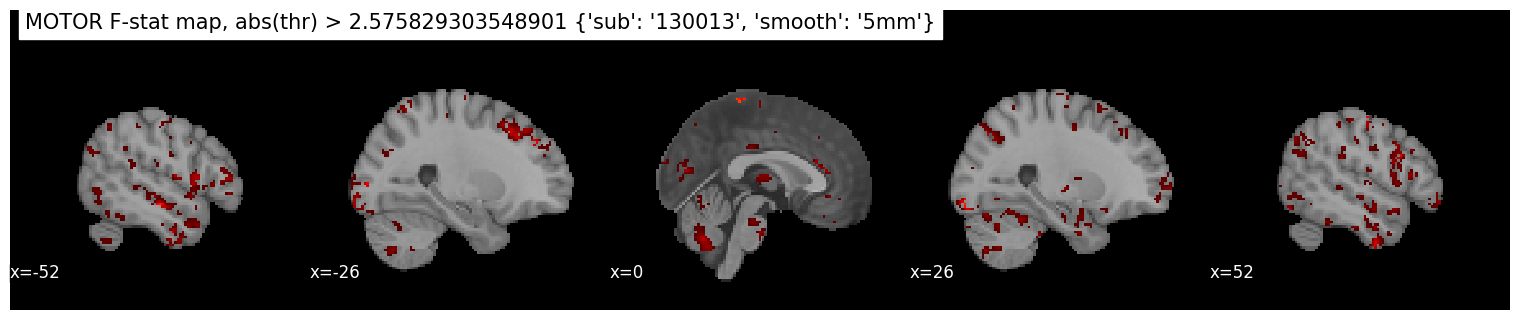

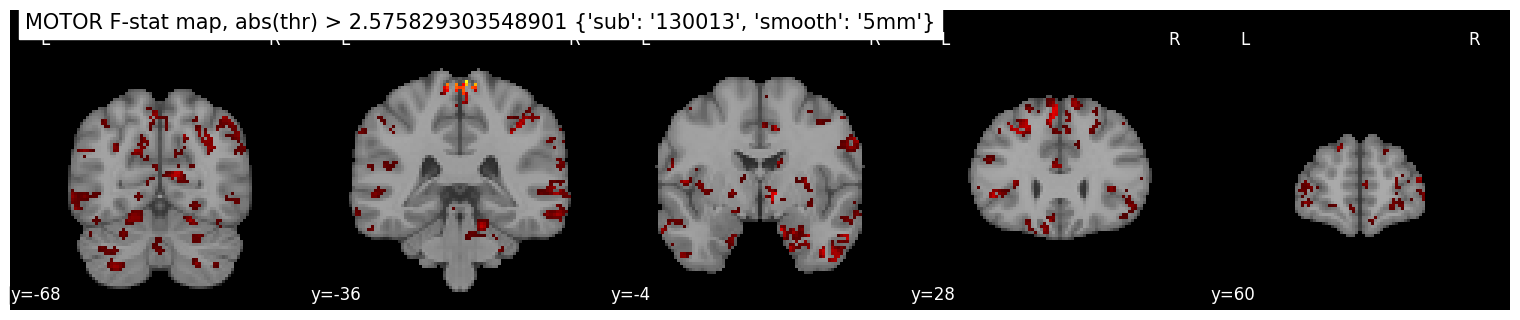

In [41]:
show_task_activation("130013", "MOTOR", "LR", smoothing=5, plot_designmatrix=False, cluster_size=10)

In [1]:
# show_task_activation("130013", "MOTOR", "RL", smoothing=5, plot_designmatrix=False, cluster_size=10)

In [12]:
from utils import processed_event

def create_events_df(subject, task, acquisition, plot_regressors=False, save_csv=True, drop_non_paradigm=True):
    proced_event = processed_event(subject, task, acquisition)

    filepath = pjoin(
        paradigm_dir, f"{subject}_Regressor_tfMRI_{task}_{acquisition}.mat"
    )
    print(filepath)
    data = scipy.io.loadmat(filepath)

    regressor = data["Regressor"]

    # Flatten the regressor to 1D if necessary
    regressor_flat = regressor.flatten()
    if plot_regressors:
        plt.plot(regressor_flat)

    # Initialize lists to store onset, duration, and condition (trial type)
    onsets, durations, trial_types = [], [], []

    # Identify events by iterating through the regressor
    current_condition = regressor_flat[0]
    start_time = 0  # Initial start time

    for i, condition in enumerate(regressor_flat[1:], start=1):
        if condition == current_condition:
            continue

        # Append the onset, duration, and trial type of the previous condition
        onsets.append(start_time * TR)
        durations.append((i - start_time) * TR)
        trial_types.append(f"condition_{current_condition}")

        # Update for the new condition
        current_condition = condition
        start_time = i

    # Add the last event
    onsets.append(start_time * TR)
    durations.append((len(regressor_flat) - start_time) * TR)
    trial_types.append(f"condition_{current_condition}")

    # Create the event file as a DataFrame
    events = pd.DataFrame(
        {"onset": onsets, "duration": durations, "trial_type": trial_types}
    )

    if drop_non_paradigm:
        # Remove condition 0 which is a the no-paradigm condition and reset indexes
        events = events[events["trial_type"] != "condition_0"]
        events = events.reset_index(drop=True)

    condition_counts = events["trial_type"].value_counts().to_dict()
    independent_events = copy.deepcopy(events)
    # Modify the trial_type to include the index of each event occurrence
    independent_events["trial_type"] = [
        f"{row['trial_type']}_{i}" for i, row in events.iterrows()
    ]

    if save_csv:
        print(proced_event)
        independent_events.to_csv(proced_event, index=False)

    return independent_events

/media/miplab-nas2/HCP-Data/HCP_100unrelated_TaskParadigms/113619_Regressor_tfMRI_MOTOR_RL.mat


onset  duration      trial_type
0     0.00     10.80   condition_0_0
1    10.80     11.52   condition_4_1
2    22.32      3.60   condition_0_2
3    25.92     11.52   condition_2_3
4    37.44     18.72   condition_0_4
5    56.16     11.52   condition_5_5
6    67.68      3.60   condition_0_6
7    71.28     11.52   condition_1_7
8    82.80      3.60   condition_0_8
9    86.40     11.52   condition_3_9
10   97.92     18.00  condition_0_10
11  115.92     11.52  condition_4_11
12  127.44      3.60  condition_0_12
13  131.04     11.52  condition_5_13
14  142.56      4.32  condition_0_14
15  146.88     11.52  condition_2_15
16  158.40      3.60  condition_0_16
17  162.00     11.52  condition_3_17
18  173.52      3.60  condition_0_18
19  177.12     11.52  condition_1_19
20  188.64     15.84  condition_0_20

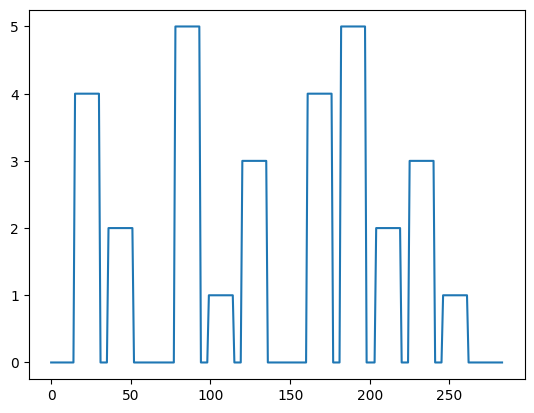

In [13]:
create_events_df(subject, tasktype, acquisition, plot_regressors=True, save_csv=False, drop_non_paradigm=False)

/media/miplab-nas2/HCP-Data/HCP_100unrelated_TaskParadigms/113619_Regressor_tfMRI_MOTOR_RL.mat


onset  duration     trial_type
0   10.80     11.52  condition_4_0
1   25.92     11.52  condition_2_1
2   56.16     11.52  condition_5_2
3   71.28     11.52  condition_1_3
4   86.40     11.52  condition_3_4
5  115.92     11.52  condition_4_5
6  131.04     11.52  condition_5_6
7  146.88     11.52  condition_2_7
8  162.00     11.52  condition_3_8
9  177.12     11.52  condition_1_9

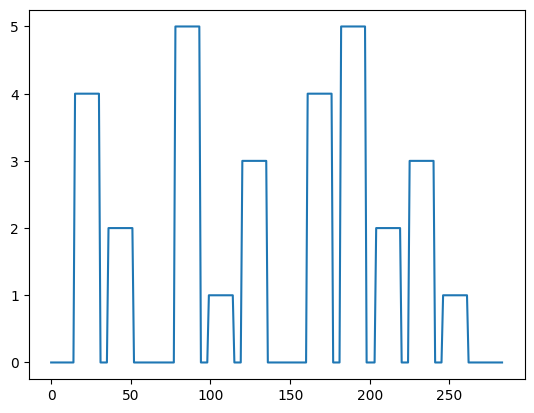

In [14]:
create_events_df(subject, tasktype, acquisition, plot_regressors=True, save_csv=False, drop_non_paradigm=True)